# Import

!pip install numpy
!pip install pandas
!pip install nltk
!pip install tqdm
!pip install gensim
!pip install spacy
!pip install scikit-learn
!pip install matplotlib
!python -m spacy download en_core_web_lg

In [ ]:
!pip install numpy
!pip install pandas
!pip install nltk
!pip install tqdm
!pip install gensim
!pip install spacy
!pip install scikit-learn
!pip install matplotlib
!pip install sentence-transformers
!python -m spacy download en_core_web_lg
import spacy.cli

spacy.cli.download("en_core_web_lg")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 5.7 MB/s 
     |████████████████████████████████| 4.2 MB 67.0 M

In [ ]:
import numpy as np
import pandas as pd
import nltk
import tqdm
from nltk.corpus import stopwords
import re,string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import gc
import gensim
import collections
nlp = spacy.load('en_core_web_lg')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 500
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [ ]:
# fixing random seed to make the experiments reproducible
np.random.seed(31415)

# Data

In [ ]:
#df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
#df.head()
#out_path='vr_ar_classification_output.xlsx'
#df=df.dropna(axis='index')
#df['sentence'] = df['sentence'].astype("string")
#print(df.info())

In [ ]:
df = pd.read_excel('besprovodnaya_svyaz__0_95_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability','class'],axis=1)
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())
out_path='besprovodnaya_svyaz__0_95_classification_output.xlsx'  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28942 entries, 0 to 28947
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  28942 non-null  string
dtypes: string(1)
memory usage: 452.2 KB
None


In [ ]:
#df = pd.read_excel('neur_ai_classification.xlsx')
#df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
#df=df.dropna(axis='index')
#df['sentence'] = df['sentence'].astype("string")
#print(df.info())
#out_path='neur_ai_classification_out.xlsx'

# Preprocessing

In [ ]:
gc.collect()
# convert to lower case, remove punctuation and numbers, replace dollar and euro signs with words. 
# remove double spaces
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text= re.sub(r'%', ' percent ', text)
    text=re.sub('\$', ' dollar ', text)
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub('\s+', ' ', text)  
    return text

In [ ]:
# a list of uninformative short words that used to be acronyms 
# or a private name. meaningful ones are not included bad', 'bag', 'bal', 'box', 'bug'
not_informative_short_words =['aaa', 'acc', 'abi', 'add', 'adt', 'aec', 'afp', 'ana', 'aol', 'apr', 'arc', 'ars', 'ash', 'atm',
                              'aud', 
                              'aug', 'avr', 'awp', 'bay', 'bbm', 'bcc', 'bci', 'ben', 'ble', 'bmi', 'boo', 'cad', 'cap', 'cbs', 
                              'ccd', 'ccp', 'ccs', 'cds', 'cee', 'ces', 'cfo', 'cgi', 'cis', 'cld', 'cns', 'cny', 'cpa', 'cta', 
                              'cto', 'cub', 'cup', 'daf', 'dan', 'daz', 'dci', 'ddr', 'dev', 'dew', 'dfc', 'dgx', 'dip', 'dlc', 
                              'dpb', 'dpi', 'dre', 'eap', 'ebt', 'eco', 'edr', 'eli', 'ems', 'eon', 'eos', 'epa', 'era', 'esa', 
                              'esi', 'etc', 'etf', 'evo', 'faa', 'fab', 'fax', 'fda', 'fed', 'fee', 'fig', 'fis', 'fla', 'fov', 
                              'gag', 'gcg', 'gdp', 'gfk', 'ghz', 'gic', 'glu', 'gos', 'gsm', 'gta', 'gtc', 'gtg', 'gtx', 'hai', 
                              'hbo', 'hed', 'hes', 'hfr', 'hlm', 'hlp', 'hmd', 'hmi', 'hon', 'htv', 'hub', 'hud', 'iab', 'iae', 
                              'ian', 'iap', 'ibd', 'ibm', 'ics', 'idc', 'idg', 'ifa', 'ign', 'igt', 'ihs', 'iii', 'imu', 'inc', 
                              'ind', 'int', 'ion', 'iot', 'ips', 'ise', 'isp', 'iss', 'ive', 'iyl', 'jio', 'jmi', 'jon', 'jun', 
                              'jwn', 'khz', 'kit', 'kwh', 'lab', 'lap', 'las', 'lbe', 'lcd', 'led', 'lgs', 'liu', 'low', 'lpm', 
                              'lrn', 'ltd', 'lte', 'lti', 'lux', 'mah', 'met', 'mhl', 'mid', 'mlg', 'mmo', 'mpg', 'mph', 'mrc', 
                              'mri', 'msc', 'msm', 'msv', 'nab', 'nba', 'nbc', 'nea', 'nfl', 'ngr', 'nov', 'nox', 'npd', 'nsf', 
                              'nsn', 'ntt', 'nuc', 'nzd', 'oak', 'oct', 'odv', 'oem', 'ohm', 'ooh', 'opi', 'opt', 'ore', 'org', 
                              'owc', 'par', 'pbr', 'pci', 'pcs', 'pct', 'phd', 'pic', 'plc', 'ppb', 'ppd', 'ppi', 'ppm', 'pre', 
                              'prn', 'pwc', 'qct', 'qqq', 'qsi', 'qtl', 'rec', 'rig', 'rim', 'rmb', 'roy', 'rpm', 'rtx', 'rue', 
                              'sad', 'sam', 'sas', 'sci', 'sek', 'shp', 'skf', 'sne', 'soc', 'spx', 'sqm', 'srp', 'stx', 'sub', 
                              'swp', 'tap', 'tcl', 'tel', 'tfe', 'thd', 'tim', 'tmr', 'tri', 'tvs', 'uav', 'ubi', 'uhd', 'uks', 
                              'usc', 'utm', 'uva', 'uvb', 'vcs', 'vfr', 'vic', 'von', 'vrd', 'vrs', 'vrx', 'wen', 'wii', 'win', 
                              'wow', 'wwe', 'wwf', 'xie', 'xlk', 'yaw', 'yoy', 'zhu', 'zvi',
                              'aal', 'aap', 'abb', 'abd', 'abp','abu', 'aci', 'acm', 'act', 'ada', 'adi', 'adl', 'adn', 'adr', 
                              'ads', 'aed', 'aeg', 'aep', 'aer', 'afr', 'agg', 'agm', 'agr', 'aha', 'ahs', 'aid', 'aii','ais',
                              'aka', 'ala', 'ali', 'alp', 'als', 'amc', 'ami', 'amn', 'amp', 'amr', 'amt', 'and', 'ant', 'anz',
                              'aok', 'api', 'app', 'aps', 'ari', 'asp', 'asu', 'asx', 'atc', 'ate', 'ati', 'atl', 'atp', 'att',
                              'atw', 'awd', 'aws', 'bac','bbb', 'bbc', 'bbk', 'bcd', 'bce', 'bch', 'bcs', 'bdt', 'beh', 'bet', 
                              'bhp', 'bia', 'bid', 'bif', 'big', 'bin', 'bip', 'bit', 'bli', 'bln', 'blu', 'bmo', 'bms', 'bmw',
                              'bns', 'bpd', 'bpi', 'bpo', 'bps', 'brl', 'bse', 'bss', 'btc', 'bts', 'btu', 'buf', 'bui','bwa', 
                              'byo', 'cae', 'caf', 'cak', 'cbp', 'ccg', 'cch', 'cci', 'ccl', 'cdc', 'cdn', 'cea', 'cem','cfe',
                              'cfs', 'cfu', 'cfx', 'cgo', 'cha', 'chd', 'chf', 'chi', 'chl', 'cho', 'chu', 'cia', 'cin', 'cio',
                              'cit', 'ckd', 'cle', 'clp',  'cmk', 'cmo', 'cmr', 'cms', 'cmt', 'cnb', 'cnc', 'cng', 'cnw', 'com',
                              'con', 'coo','co₂', 'cpc', 'cpe', 'cph', 'cpi', 'cps','cpv', 'cpw', 'crm', 'cry', 'cse', 'csl', 
                              'csm', 'csp', 'csr', 'css', 'cus', 'cut', 'cvc', 'cvg', 'cyn', 'czk', 'dab', 'dal', 'dam', 'das',
                              'dax',  'dbs', 'dcg', 'dcm', 'dda', 'ddh', 'ddt', 'dec', 'del', 'den', 'der', 'des', 'det', 'dft',
                              'dha', 'dhl', 'dhq', 'dig', 'div', 'diy', 'djb', 'dld', 'dlr', 'dmi', 'dmr', 'dna', 'dng', 'doe',
                              'dou', 'dow', 'dsc', 'dsl', 'dso', 'dsp', 'dtc', 'dth', 'dtl', 'dts', 'dtw', 'due', 'dug', 'duo',
                              'dvb',  'dvr', 'dxb', 'eas','ebs', 'eda', 'edm', 'edt', 'eee', 'ees', 'efb', 'egp', 'ehr', 'ehs',
                              'eia', 'eid', 'eir', 'emc', 'emd', 'emi', 'emt', 'emv', 'end', 'eno', 'ent', 'epc', 'epi',  'eqb',
                              'erc', 'ers', 'eso', 'est', 'etb', 'etd', 'ett', 'eur', 'eus', 'evf', 'evm', 'evs', 'ewj', 'ews',
                              'eye', 'fao', 'fat', 'fba', 'fca', 'fcc', 'fcf', 'fci', 'fcs', 'fdi', 'fdn', 'feb', 'fgw','flo',
                              'fly', 'fmc', 'fmi', 'fni', 'fon','fsa', 'fsi', 'fss', 'fst', 'ftc', 'ftr', 'fun', 'fwa', 'fxi', 
                              'gaa', 'gal', 'gan', 'gao', 'gba', 'gbe', 'gby', 'gcf', 'gee', 'gen', 'ges', 'get', 'gfg', 'ggv',
                              'ghg', 'ghs', 'gif', 'gig', 'giv', 'gla', 'gmt', 'gmv', 'gni', 'gnw', 'gpv', 'grm', 'gru', 'gsa',
                              'gsi', 'gsk', 'gst', 'gth', 'gtm', 'gto', 'gun', 'guo', 'gut', 'gva', 'gvt', 'gwe', 'gwh', 'gør',
                              'han', 'har', 'hat', 'hba', 'hbb', 'hcc', 'hcl', 'hdb', 'hdd', 'hdi', 'hdr', 'hdx', 'hem', 'hev', 
                              'hex', 'hey', 'hfc', 'hia', 'hip', 'hit','hkd', 'hkx', 'hlr', 'hns', 'hos', 'hou', 'hpc', 'hpe',
                              'hpj', 'hps', 'hrb', 'hrs', 'htc', 'hts', 'htt', 'hua', 'høy', 'iac', 'ibs', 'ibw', 'ica', 'icn',
                              'icp', 'ict', 'ida', 'idf', 'idh', 'idp', 'idx', 'ied', 'iee', 'ift', 'igr', 'igv', 'iia', 'iin', 'ijj',
                              'ill', 'imf', 'img', 'imo', 'ims', 'ina', 'ing', 'ink', 'inn', 'inr', 'ins', 'ioc', 'ioe', 'ios', 'ipc',
                              'ipd', 'ipo', 'ipr', 'ipv', 'ipx', 'iri', 'irs', 'isi', 'ism', 'itc', 'itm', 'itu', 'itv', 'iuc', 'iwd',
                              'iwf', 'iwr', 'iyt', 'izy', 'jam', 'jan', 'jet', 'jfk', 'jgp', 'jim', 'job', 'jpr', 'jpy', 'jqh', 'jsc',
                              'jui', 'jul', 'kan', 'kfc', 'kgi', 'kgs', 'kid', 'kik', 'kim', 'kkr', 'kla', 'klm', 'kmi', 'kms', 'km²',
                              'koa', 'kph', 'kpn', 'krw', 'kse', 'kts', 'kun', 'kuo', 'kva', 'kvh', 'kwd', 'laa', 'lag', 'lam', 'lan',
                              'lat', 'law', 'lay', 'lbs', 'lcc', 'lce', 'lco', 'lda', 'ldc', 'lee', 'les', 'let', 'lex', 'lgb', 'lie',
                              'lis', 'lla', 'llc', 'lmc', 'lmr', 'lng', 'log', 'loi', 'lok', 'los', 'lot', 'lpg', 'lps', 'lrs', 'lse', 
                              'lsi', 'lsp', 'lsr', 'ltm', 'lui', 'luk', 'lum', 'luo', 'lyf', 'lzo', 'lzt', 'mab',  'mag', 'man',
                              'map', 'mar', 'mat', 'mau','mbb', 'mbs', 'mbu', 'mca', 'mcd', 'mcm', 'mco', 'mdd', 'mdg', 'mdm', 'mdr', 'mea',
                              'med', 'mee', 'mem',  'meq', 'mfi', 'mhi', 'mhs', 'mhz', 'mic', 'mik', 'mil', 'mim',  'mio', 'mir', 'mis',
                              'mit', 'mix', 'mjn', 'mln', 'mms', 'mmt', 'mnf', 'mno', 'mnp', 'mod', 'mog', 'mom', 'mos', 'mou', 'moz',    
                              'mpa', 'mpc', 'mpd', 'mps', 'mrm', 'mro', 'mrp', 'msa', 'msi', 'msn', 'mss', 'mst', 'mtg', 'mtl', 'mtn', 'mts',
                              'mvp', 'mwc', 'mwh', 'máv', 'nas', 'nbn', 'ncr', 'nec', 'net', 'new', 'nfc', 'nff', 'nfv', 'ngh', 'nhk', 'nhn',
                              'nhs', 'nis', 'nok', 'non', 'npt', 'nre', 'nrf', 'nrg', 'nse', 'nsl', 'nsr', 'nsw', 'ntc', 'ntd', 'ntf', 
                              'ntp', 'ntv', 'nwe', 'nws', 'nxp', 'nxt', 'nyg', 'nyj', 'obd', 'obr', 'obs', 'ocf', 'och', 'ocs', 'odd',
                              'odm', 'oee', 'oes', 'ohb', 'oie', 'oil', 'old', 'one', 'ono', 'ons', 'ont', 'orc', 'oro', 'orr', 'osa',
                              'osk', 'ota', 'otc', 'ott', 'owe', 'oza', 'pac', 'pad', 'pan','pbs', 'pbx', 'pcb', 'pch', 'pcl', 'pcp',
                              'pds', 'pdv', 'peg', 'per', 'pet', 'pew', 'pgh', 'phe', 'phl', 'pie', 'pig', 'pin', 'pit', 'pkr', 'pla',
                              'pld', 'plm', 'pls', 'ply', 'pme', 'pnb', 'pod', 'pop', 'pos', 'pot', 'ppg', 'ppp', 'pps', 'ppv', 'prc',
                              'pro', 'prp', 'psg', 'psi', 'psy', 'pta', 'ptp', 'pts', 'pub', 'put', 'pvc', 'pyg', 'qad', 'qar',
                              'qcc', 'qfy', 'qhd', 'qnx', 'qoq', 'qvc', 'rac', 'raj', 'ram', 'ran', 'raw', 'ray', 'rba', 'rbc',
                              'rbi', 'rca', 'rcr', 'rcs', 'rda', 'rdd', 'red', 'ree', 'ren', 'rev', 'rex', 'rey', 'rgb', 'rgu', 
                              'rhi', 'rid', 'ril', 'rio', 'rkg', 'rmg', 'rmi', 'rmr', 'roa', 'roc', 'rod', 'roe', 'rog', 'roi',
                              'rom', 'ron', 'rov','rrb', 'rrh', 'rsa', 'rse', 'rsi', 'rtk', 'rub', 'run', 'rwc', 'saf', 'san',
                              'sao', 'sap', 'sar', 'sat','sba', 'sbc', 'sbi', 'sbo', 'sce', 'scs', 'sdg', 'sdn',
                              'sea', 'sec', 'see', 'sel', 'sen', 'sep', 'ses', 'set', 'sex', 'sfr', 'sgt', 'sgx', 'shy', 
                              'sia', 'sim', 'sis', 'sit', 'siy', 'ski', 'skm', 'skt', 'sky', 'slp', 'smb', 'sme', 'smg',
                              'smh', 'smk', 'smp', 'sms', 'smt', 'sns', 'soi', 'sol', 'som', 'son', 'sot', 'soy', 'spg',
                              'sph', 'spi', 'spy', 'sri', 'ssa', 'ssd', 'sse', 'ssl', 'ssm', 'std', 'stl', 'stp', 'sts',
                              'stv', 'suc', 'sud', 'sui', 'sum', 'sun', 'sur', 'suv', 'svp', 'svw', 'tab', 'tac', 'tad',
                              'tag', 'tal', 'tam', 'tan', 'tas',  'tbr', 'tbs', 'tcf', 'tcm', 'tco', 'tcs', 'tdd',
                              'tdi', 'tdk', 'tec', 'tek',  'ter', 'tex', 'tfa', 'tft', 'the', 'thz', 'tie', 'til', 
                              'tio', 'tip', 'tis', 'tls', 'tms', 'tom', 'ton', 'tpg', 'tpv', 'tpy', 'tre', 'try', 
                              'tsa', 'tse', 'tsr', 'tuc', 'tvb', 'tvc', 'twc', 'twh', 'two', 'txn', 'uae', 'uah', 
                              'ual', 'ubm', 'ubs', 'ucs', 'ufs', 'uhf', 'uhs', 'ulm', 'umc', 'und', 'une', 'upc', 
                              'upi', 'upm', 'ups', 'uqc', 'ure', 'usa', 'usb', 'usd', 'use', 'usf', 'uss', 'usv', 
                              'val', 'van', 'var', 'vas', 'vat', 'vdc', 'vdd', 'ver', 'vfc', 'vha', 'vhf', 'via',
                              'vil', 'vis', 'vnf', 'vni', 'voc', 'vod', 'vpn', 'vrf', 'vtr', 'vzw', 'wal', 'wan',
                              'wap', 'war', 'wav', 'wba', 'web', 'wed', 'wes', 'wet', 'wls', 'wos', 'wpc'
                              , 'wsj', 'wsn', 'wtg', 'www', 'xad', 'xfi', 'xia', 'xin', 'xlv', 'xmi', 'xps', 'xrp',
                              'xue', 'xzz', 'yds', 'yea', 'yen', 'yep','yfm', 'yin', 'ysa', 'ytd', 'yum', 'yun', 'zal',
                              'zee', 'zem', 'zte', 'zto',
                             'aao','abt', 'aca', 'acd', 'ach', 'ack', 'acl', 'acn', 'aco', 'acr', 'acs', 'acv', 'adb', 'adj', 'ado', 
                              'adp','aes', 'aet', 'afl', 'agc', 'agh', 'agi', 'agn','ags', 'agv', 'ahn', 'ahu', 'aig', 'alm', 'alt', 'ama',
                              'ame', 'aml', 'ams', 'amv', 'amy', 'anc','ann', 'aoc', 'aog', 'aon', 'aov', 'apa', 'apd', 'apl', 'apm', 'aqr',
                              'arr','asa', 'asc', 'asd', 'asm', 'asr', 'ata', 'atd', 'ato', 'auf', 'aum','avx', 'awe', 'axa', 'ayx', 'baa',
                              'bam', 'ban', 'bao', 'bar', 'bax', 'bba', 'bbl', 'bca', 'bcf', 'bcm', 'bct', 'bda', 'bdc',
                              'bdo', 'bds', 'bec','bep', 'bgc', 'bgf', 'bgr', 'bhi', 'bim', 'bio', 'bis', 'biu', 'biz', 'bjh', 'bjp',
                              'bjs', 'bkc', 'bkw', 'bls', 'bmc', 'bnp', 'bob', 'boe', 'bol','bpl', 'bpm', 'bpt', 'bra', 'bsa', 'bsi', 'bsv',
                              'bsx', 'bti', 'btl', 'bto', 'btw', 'bud', 'buz', 'bwc', 'cab', 'cac', 'cba', 'cbd', 'cbi', 'cbm', 'cca', 'ccb', 
                              'ccc', 'ccm', 'ccr', 'cdg', 'cdi', 'cdk', 'cdo', 'cdw', 'cdx', 'ceb', 'cec', 'cef', 'cel', 'cep', 'cet', 'cgm',
                              'cgn', 'che', 'cic', 'cke', 'cli', 'cma', 'cme', 'cmf', 'cmi', 'cml', 'cmu', 'cnk', 'cnn', 'cnt', 'cod', 'col',
                              'cor', 'cos','cpg', 'cpm', 'cpo', 'cpp', 'cpr', 'cpt', 'cpu', 'crc', 'cro', 'crv', 'csa', 'csd', 'csf', 'csi',
                              'cso', 'ctd', 'cti', 'ctr', 'cue', 'cuh', 'cvd', 'cvs', 'cwc', 'cxa', 'cxu', 'cys', 'dag', 'dai', 'dao', 'dau',
                              'dbr', 'dcc', 'dco', 'dcp', 'dds', 'dee', 'dei', 'dem', 'dfj', 'dfm', 'dhe', 'dia', 'dif', 'dik', 'dim', 'dkk', 
                              'dkr', 'dlp', 'dls', 'dmc', 'dme', 'dmf', 'dmg', 'dms', 'dnb', 'dnf', 'dno', 'doa', 'doc', 'dod', 'doi', 'doj',
                              'dos', 'dpm', 'dpu', 'drg', 'dss', 'dte', 'dtm', 'dto', 'dtt', 'dun', 'dup', 'dut','dvm', 'dvt', 'dxl', 'dye',
                              'eab', 'eam','ecj', 'ecm', 'ecs', 'edf', 'edp', 'eds', 'edu', 'eeg', 'eff', 'efm', 'egg', 'egm', 'ein', 'eiu',
                              'ekg', 'eld', 'elf', 'ema', 'emr', 'eps', 'erm', 'erp', 'erx', 'esd', 'esn', 'esp', 'eth', 'etl', 'eva', 'exa',
                              'ext', 'eys', 'faf','faq', 'far', 'fay', 'fbi', 'fbr', 'fdp', 'fep', 'fet', 'fft', 'fia', 'fin', 'fkf', 'fld',
                              'flg', 'flu', 'fos', 'fou','fpc', 'fpl', 'fps', 'frr', 'frs', 'fse', 'fsr', 'fte', 'ftk', 'ft³', 'fup', 'fyp',
                              'gac','gbi', 'gbp', 'gbs', 'gca', 'gcc', 'gel','ggr', 'ghk', 'gii', 'gle', 'glj', 'gma', 'gms', 'goa','gox', 'gpa',
                              'grc', 'grp', 'gsr', 'gsu', 'gsv', 'guy', 'gvc', 'gwp','hal', 'hbl', 'hbs', 'hci', 'hcm', 'hcq', 'hcs', 'hdl', 'hdp',
                              'hfn', 'hfo', 'hfs', 'hft', 'hhs', 'hie', 'hiv', 'hla', 'hmh', 'hmq', 'hmx', 'hny', 'hoc', 'hot', 'hrc', 'hrd', 'hsn',
                              'htf', 'htm', 'hue', 'hut', 'hvc', 'hya', 'hzb', 'hzi', 'ias', 'ibc', 'ibn', 'ibo', 'icc', 'icd','icf', 'ico', 'icu',
                              'icy', 'idm', 'ids', 'idw', 'ieg', 'ieo', 'ifr', 'ifs', 'ifx', 'igd', 'igm', 'ihc', 'ihl', 'iis', 'ijb', 'ile', 'ime',
                              'ini', 'inv', 'iod', 'iou', 'ipa', 'ipf', 'ipu', 'iqe', 'iqf', 'irc', 'ird', 'irr', 'isc', 'isg', 'ish', 'iso', 'ist',
                              'ito', 'iva', 'ivc', 'ivf', 'ivp', 'ivr', 'ivv', 'ivy', 'iwg', 'iwv', 'ixc', 'iyk', 'iyw', 'jaw', 'jda', 'jek', 'jft',
                              'jha', 'jhu', 'jit', 'jll', 'joe', 'jog', 'joy', 'jpl', 'kai', 'kar', 'kbr', 'ken','kia', 'koc', 'koh', 'kpa', 'kyc',
                              'lal', 'lau', 'lbp', 'lcs', 'ldl', 'len', 'leo', 'lev', 'lfw', 'lgp', 'lib', 'lip', 'lit', 'liv', 'liz', 'llp', 'lns',
                              'lol', 'lpd', 'lpo', 'lpt', 'ltl', 'ltv', 'luc', 'luz', 'léo','mba', 'mcg', 'mch', 'mcp', 'mcu', 'mcx', 'mdt', 'meg',
                              'mes', 'mfp', 'mgi', 'mgm', 'mig', 'min', 'mlb', 'mld', 'mmc', 'mmp', 'mol', 'moo', 'mov', 'moy', 'mpl','msh',
                              'mso', 'msp', 'msw', 'mtf', 'mtr', 'mtu', 'mtv', 'mud', 'mug', 'mum', 'mwe', 'mws', 'myo', 'myq', 'myr', 'nac',
                              'nam', 'nap', 'nav', 'nbj', 'nbv', 'ncm', 'ncs', 'ndp', 'ndr', 'ndt', 'nei', 'neo', 'neu', 'nev', 'nex', 'nfx',
                              'nga', 'ngc', 'ngi', 'ngo', 'ngp', 'ngs', 'nia', 'nic', 'nih', 'nil', 'nir', 'njm', 'nlp', 'nlu', 'nme', 'nmp',
                              'nmr', 'nmt', 'npa', 'npg', 'npr', 'nps', 'npu', 'npv', 'nra', 'nrm', 'nsa', 'nti', 'nut', 'nxj', 'nyc', 'oab',
                              'obn', 'oca', 'oda', 'ofr', 'oht', 'oig', 'oin', 'ola', 'ole', 'omb', 'opm', 'ops', 'osc', 'osi', 'oto','pag',
                              'pak', 'pal', 'pap', 'pas', 'pat', 'pau', 'pav','pcd', 'pce', 'pcu', 'pdc', 'pdf', 'pdm', 'pec', 'pep', 'pfd',
                              'pfe', 'pfi', 'pga', 'pgi', 'phi', 'php', 'phs', 'pii', 'pim', 'piv', 'pjc', 'pln', 'plp', 'pmi', 'pmp', 'pnc',
                              'pnr', 'poo', 'pou', 'ppa', 'ppl', 'ppo', 'prb', 'prm', 'prt', 'psa', 'psp', 'psr', 'pti', 'pty', 'pud', 'pus',
                              'pvd', 'pvo', 'pvs', 'pvt', 'qia', 'qrr', 'qsr', 'qts', 'que', 'rad', 'rao', 'ras','rcm', 'rct', 'ref', 'rei',
                              'rel', 'rem', 'rep', 'rfp', 'rgc', 'rhb', 'ria', 'ris', 'riv', 'rix', 'riz', 'rna', 'rnn', 'rnr', 'rop', 'row',
                              'rpa', 'rpc', 'rpx', 'rtb', 'rte', 'rti', 'rtl', 'rtp', 'ruh', 'rvx', 'rws', 'rxn','sbb', 'sbs', 'scm', 'scp', 
                              'sdi', 'sdk', 'sdl', 'sdm', 'seo', 'seu', 'sfc', 'sfi', 'sfm', 'sfn', 'sga', 'sha', 'shu', 'sic', 'sig', 'sip',
                              'six', 'ska', 'sku', 'sla', 'slb', 'sls', 'smx', 'snf', 'snr', 'soa', 'sob', 'sou', 'sow', 'sox', 'spf', 'spr',
                              'sps', 'sqe', 'sql', 'sqs', 'src', 'srm', 'sro', 'sst', 'stm', 'sto', 'sue', 'sul', 'svb', 'sve', 'svg', 'sya',
                              'syn', 'sys', 'tao', 'tav', 'tax', 'tay', 'tba', 'tbi', 'tca', 'tcp', 'tct', 'tcv', 'tdp', 'tea', 'ted', 'tem',
                              'teo', 'teu', 'tez', 'tfm', 'tgf', 'tha', 'thb', 'the', 'tif', 'tin', 'tka', 'tko', 'tma', 'tmp', 'tmt', 'tmv',
                              'tmw', 'tns', 'tnt', 'tnw', 'toc', 'toe', 'top', 'tor', 'tow', 'toy', 'tpd', 'tpm', 'tpu', 'trp', 'tru', 'tsi', 
                              'tsv', 'tsx', 'tth', 'tty', 'tvh', 'tvm', 'tvt', 'uas', 'ucc', 'ucl', 'udx', 'ugc', 'ugo', 'uhr', 'uia', 'ulg', 
                              'ull', 'umn', 'uns', 'url', 'uth', 'uto', 'uup', 'vbs', 'vca', 'vda', 'vde', 'vdw', 'vea', 'vec', 'vgb', 'vgg', 
                              'vie', 'vig', 'vii', 'vin', 'viv', 'viz', 'vku', 'vms', 'vos', 'vpa', 'vri', 'vrt', 'vte', 'way', 'wbt', 'wcs', 
                              'wee', 'wef', 'weo', 'wer', 'wfc', 'wfe', 'wfm', 'wfo', 'wit', 'wmo', 'wmt', 'wmw', 'wns', 'wpd', 'wpi', 'wpl', 
                              'wpp', 'wsi', 'wta', 'wti', 'wwt', 'xes', 'xgs', 'xlb', 'xly','xor', 'xpo', 'xrf', 'yap', 'yeo','yrd', 'yue', 'yug',
                              'yuk', 'zaf', 'zar', 'zen', 'zev', 'zip', 'zmr', 'zoo', 'zva', 'çok']


['dj','ar','xr','hz','au','mb','va','co','rs','xs','go','rr','db','ai','tb','os','mp','vs','vp','gb','rf','pm','ml','xp','px','ea','mm','kg','km','mi','hd','ds','ky','tv','ks','fb','hp','nm','ad','µm','sq','uk','bn','kw','cu','sv','th','st','la','sh','lg','ft','ii','ic','ct','vc','mn','xx','bi','id','cb','ap','du','qq','en','sg','ms','bb','pf','ag','li','ka','fy','mr','mc','gm','im','ts','wi','fi','ac','br','nr','av','cd','gp','fm','dr','ha','su','de','rd','xa','eu','sf','mw','oz','lb','ef','hs','wc','cm','ex','gt','gs','rg','bg','mt','je','ip','ed','ey','dc','lu','wu','ev']

In [ ]:
# removal of English particles and prepositions.
all_stopwords = stopwords.words('english')
def delete_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [ ]:
df['Clean_sentence']=df['sentence'].apply(lambda x: preprocess(x))
df['Clean_sentence']=df.Clean_sentence.apply(delete_stop_words)
#delete short words in 2 characters
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x:' '.join( [w for w in x.split() if len(w)>2]))
#delete uninformative words from the list above
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x:' '.join( [w for w in x.split() if w not in not_informative_short_words]))
df.head()

,sentence,Clean_sentence
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis


In [ ]:
  #  'communitiesnjfr', 'proceedingfacebook', 'communitybrands', 'marketaccording', 'researchinchina', 'contributionstensorflow', 'representatives', 'undernourishment', 'nanotechnologies', 'underhandedness', 'misidentification', 'shareblackberry', 'authentications', 'leveragedinitial', 'mobilethroughout', 'disproportionately', 'balasubramanian', 'implementations', 'biometricupdate', 'bioluminescence', 'retrotransposon', 'diversification', 'infrastructures', 'vulnerabilities', 'aroundveritasium', 'representational', 'konstantopoulos', 'ventriloquizing', 'unsettlingwherever', 'electrochemical', 'potentiostatically', 'electrospinning', 'differentiation', 'controlparticularly', 'photoprotection', 'radiopharmaceuticals', 'complyadvantage', 'cathodoluminescence', 'supercapacitors', 'nanoparticulate', 'advertisementadjusted', 'phacoemulsification', 'getelementsbytagname', 'popularapproximately', 'blepharoconjunctivitis', 'hyperpigmentation', 'pharmaceuticals', 'coadministration', 'betadataquantadatas', 'unsaponifiables', 'cyclohexylgriselimycin', 'microdermabrasion', 'recommendations', 'electrocatalyst', 'characteristics', 'worldwideenough', 'hexafluorophosphate', 'australopithecus', 'pathophysiology', 'reportsnreports', 'majorcytogenetic', 'cabozantinibarm', 'discontinuations', 'proteobacterium', 'crystallisation', 'environmentally', 'vascularization', 'supplementation', 'membranefiltered', 'ultrafiltration', 'exopolysaccharide', 'multituberculate', 'commercialization', 'palaeoanthropology', 'polyhexylthiophene', 'healthcarestudies', 'realistaccording', 'communitiesless', 'transparencymarketresearch', 'bioinformatician', 'representationword', 'geturlinsidetweet', 'tidytweetistanbul', 'geturlinsideretweet', 'advertisementbut', 'deploymentwhich', 'hospitalizations', 'extraordinarily', 'responsibilities', 'advertisementneither', 'translationalthough', 'advertisementover', 'confidentiality', 'interestflittos', 'advertisementrevenues', 'advertisementour', 'advertisementspam', 'enterprisesmarch', 'taikatranslations', 'highlightscorporatebaidu', 'advertisementinitial', 'advertisementaccording', 'advertisementvaluation', 'advertisementmeanwhile', 'advertisementlanguage', 'advertisementaround', 'translationrozetta', 'thrivedlifvergren', 'technologieshttps', 'kilgraycontactsandor', 'preprocessingthe', 'advertisementthis', 'advertisementinitially', 'advertisementfounded', 'partnersportola', 'advertisementsurveyed', 'discountfurthermore', 'employmentwhich', 'counterintuitive', 'underprivileged', 'advertisementhow', 'transformationindia', 'localgovernment', 'acquisitionsthe', 'everyoneaccording', 'journeydineouts', 'complementarity', 'transformational', 'franciscofacebook', 'implementationcreated', 'lendingcrowdthe', 'indiaautomotive', 'pricewaterhouse', 'personalisation', 'telecommunication', 'unapologetically', 'relationshipsmobile', 'popularityfacebook', 'nonprofitssourcechalk', 'procrastination', 'worldwidesource', 'internationally', 'alliedmarketresearch', 'environmentspeople', 'conclusionaccording', 'messengerfacebook', 'humansaccording', 'cryptocurrencies', 'developmentsecretive', 'humantelligence', 'interconnections', 'landscapeaccording', 'magazineaccording', 'videosaccording', 'businessinsider', 'fiercehealthcare', 'marketingmarketing', 'intelligenceallscripts', 'characterization', 'borsadelcredito', 'healthcareitnews', 'interestmaximize', 'educationvirtual', 'disintermediation', 'bankingaccording', 'returnersproving', 'databasefacebook', 'synchronisation', 'significantmobile', 'postcodeschinapyramid', 'penaltiesfacebook', 'kingdomratesetter', 'deliverabilityroughly', 'entrepreneurial', 'accountstwitter', 'americanexpress', 'competitiveness', 'businessaccording', 'advertisementgermanys', 'underrepresented', 'servicesinfrastructure', 'environmentshybrid', 'businessinsiders', 'edigitalresearch', 'zenithoptimedia', 'internationalsome', 'drivenprimarily', 'operationsintuit', 'fundingaustralian', 'personalizationprevious', 'millionwhatsapp', 'matchupsbroadcast', 'advertisementadvertisementnow', 'marketingaccording', 'advertisementin', 'changesprevious', 'milestonesfiretvamazon', 'purchaseswhilst', 'growthliulishuo', 'assistantsnuance', 'electrification', 'measurementsabout', 'marketstudyreport', 'reclassification', 'communicationmuch', 'transcriptionists', 'accomplishments', 'dissatisfaction', 'bundesnetzagentur', 'videoconferencing', 'smartphoneswith', 'clevelandclinic', 'biopharmaceutical', 'storyconnecticut', 'followsmeanwhile', 'unbankedwithout', 'cadburycraveyard', 'fivethirtyeight', 'possibilitiesbaidu', 'transparencyaccentures', 'advanceaccording', 'intelligencethe', 'entrepreneurship', 'optimizationsmobile', 'traditionalists', 'automationmeaning', 'revenuemediatek', 'interoperability', 'functionalities', 'infrastructuresoperators', 'informationphilips', 'caregiversbetter', 'discoverability', 'cryptocurrencyat', 'companiesamerican', 'advertisementroku', 'cherokeeengines', 'transmissionsall', 'intelligencecigna', 'powerwallswedish', 'intelligencehealth', 'josephpisanisign', 'newsletterscopyright', 'superpedestrians', 'advertisementlast', 'respondentsdouble', 'pessimistically', 'keeptheweatherchannel', 'entrepreneurism', 'reproducibility', 'informationebitda', 'algorithmically', 'marriottmarriottover', 'compareasiagroup', 'productsnonbook', 'turnoveramazons', 'bronchodilators', 'thefreshwatertrust', 'pharmacokinetic', 'physicochemical', 'azithromycinthe', 'bnamericasbrazilian', 'nongovernmental', 'hospitalization', 'powerhydroelectric', 'helsinkishanghai', 'industryaccording', 'automationplatforms', 'cybercriminalslaunch', 'underemployment', 'siriusdecisions', 'planningaccording', 'transformations', 'expensessubsidies', 'incomeoperating', 'resultsrevenuesin', 'expensesselling', 'projectionswall', 'intrapreneurship', 'hotpaperlantern', 'automationautomation', 'octoberbetterhalf', 'accesshealthcare', 'ascensionventures', 'opinionsmanagement', 'increasednumber', 'centidentifying', 'leaderscompanies', 'salaryfinancethe', 'securitizations', 'professionsincluding', 'accountingeliminated', 'technologieswith', 'immunohistochemistry', 'securitysolutions', 'centralgovernment', 'incidentsinvolved', 'companiesincreasingly', 'fraudulenttransactions', 'musculoskeletal', 'intelligencewhen', 'bestblackfriday', 'instrumentation', 'acquisitionunder', 'intelligenceportals', 'companiescompany', 'increaserevenue', 'neuromodulation', 'rehospitalization', 'standardization', 'administrations', 'familienversicherung', 'connectivitynokia', 'informationsaid', 'vulnerablespend', 'maintenanceaccording', 'connectionsresponded', 'trendsanalytics', 'researchnreports', 'notwithstanding', 'criminalization', 'ineffectiveness', 'accenturestrats', 'experiencesforty', 'uniontransferwise', 'hyperspecialization', 'problematically', 'htfmarketreport', 'zionmarketresearch', 'innovationcited', 'enginestotaling', 'orderconversely', 'profitgenerator', 'improvementdespite', 'ultimarketingweb', 'playersincluding', 'programmatically', 'assistancealthough', 'correspondingly', 'businesscustomers', 'deathcardiovascular', 'administratives', 'synchronization', 'pinnaclepushing', 'microtransaction', 'eyefortransport', 'productselastic', 'surfacesincluding', 'fieldsreplacing', 'financialsfirst', 'analyticsalmost', 'facebookconnectivitythe', 'cannibalization', 'financialsfacebooks', 'capitalpredicted', 'customersdelivering', 'fiercehealthpayer', 'pricewatershousecooper', 'platformmachine', 'trillionbasically', 'environmentshave', 'thorvaldsdottir', 'neijenslandsvirkjun', 'hospitalisations', 'blockingpagefair', 'realityconversely', 'underperforming', 'productseverything', 'institutionalisation', 'conclusionpositiverevenue', 'interactionspurchases', 'computationally', 'billionrepresenting', 'madisonvaccines', 'glaxosmithkline', 'thehalifaxgroup', 'appliedproteomics', 'maturesignificantly', 'renewableenergyworld', 'revolutionanalytics', 'proteusdigitalhealth', 'devicescurrently', 'gastrointestinal', 'characterizations', 'recapitalization', 'interradmedical', 'biopharmaceuticals', 'smartdatacenter', 'scientificconservation', 'neurotechnology', 'philanthropists', 'superconducting', 'advertisementteslas', 'profileprofessor', 'francisprofessorsir', 'electromagnetic', 'membersaccording', 'neuroprosthesis', 'colibasanujapans', 'electroencephalography', 'desertification', 'neurobiological', 'transplantation', 'personaltypically', 'epidemiological', 'neurophysiology', 'nasopharyngitis', 'incobotulinumtoxina', 'prolongedaffects', 'bupivacaineinjections', 'reduceddependence', 'hypersensitivity', 'anddipyridamole', 'atherosclerotic', 'dextromethorphan', 'psychopathology', 'neuroprosthetics', 'rehospitalizations', 'echocardiography', 'lacerationintentional', 'reinterventions', 'revascularization', 'anticoagulation'

In [ ]:
# replacing large words derived from errors by a few words.
def preprocess_words(text):
    text = text.lower()
    text= re.sub('centralgovernment', 'central government', text)
    text= re.sub('incidentsinvolve', 'incidents involve', text)
    text= re.sub('mobilethroughout', 'mobile throughout', text)
    text= re.sub('biometricupdate', 'biometric update', text)
    text= re.sub('advertisementadjuste', 'advertisement adjuste', text)
    text= re.sub('capitalpredicte', 'capital predicte', text)
    text= re.sub('facebookconnectivitythe', 'facebook connectivity the', text)
    text= re.sub('financialsfirst', 'financials first', text)
    text= re.sub('financialsfacebook', 'financials facebook', text)
    text= re.sub('researchnreport', 'research n report', text)
    text= re.sub('accesshealthcare', 'access health care', text)
    text= re.sub('proteusdigitalhealth', 'proteus digital health', text)
    text= re.sub('renewableenergyworld', 'renewable energy world', text)
    text= re.sub('blockingpagefair', 'blocking page fair', text)
    text= re.sub('thesupermariobro', 'the supermario bro', text)
    text= re.sub('basicsmessenger', 'basics messenger', text)
    text= re.sub('communitybrands', 'community brands', text)
    text= re.sub('contributionstensorflow', 'contributions tensorflow', text)
    text= re.sub('opinionsmanagement', 'opinions management', text)
    text= re.sub('increasednumber', 'increased number', text)
    text= re.sub('salaryfinancethe', 'salary finance the', text)
    text= re.sub('securitysolution', 'security solution', text)
    text= re.sub('reduceddependence', 'reduced dependence', text)
    text= re.sub('bupivacaineinjection', 'bupivacaine injection', text)
    text= re.sub('hypersensitivity', 'hyper sensitivity', text)
    text= re.sub('membersaccording', 'members according', text)
    text= re.sub('francisprofessorsir', 'francis professors ir', text)
    text= re.sub('profileprofessor', 'profile professor', text)
    text= re.sub('advertisementtesla', 'advertisement tesla', text)
    text= re.sub('scientificconservation', 'scientific conservation', text)
    text= re.sub('respondentsdown', 'respondents down', text)
    text= re.sub('chatbotfacebook', 'chatbot facebook', text)
    text= re.sub('beforetrademark', 'before trademark', text)
    text= re.sub('marketresearchhub', 'market research hub', text)
    text= re.sub('heavyweightshive', 'heavy weights hive', text)
    text= re.sub('conclusioncitron', 'conclusion citron', text)
    text= re.sub('manufacturingwhich', 'manufacturing which', text)
    text= re.sub('globalfoundries', 'global foundries', text)
    text= re.sub('advertisementgoldman', 'advertisement goldman', text)
    text= re.sub('technologyeverything', 'technology everything', text)
    text= re.sub('coherentmarketinsights', 'coherent market insights', text)
    text= re.sub('advertisementmore', 'advertisement more', text)
    text= re.sub('breakdowndownload', 'break downdownload', text)
    text= re.sub('growthaccording', 'growth according', text)
    text= re.sub('technologytiktok', 'technology tiktok', text)
    text= re.sub('proceedingfacebook', 'proceeding facebook', text)
    text= re.sub('technologysmartphone', 'technology smartphone', text)
    text= re.sub('technologiesresearch', 'technologies research', text)
    text= re.sub('tesseraholdingcorporation', 'tessera holding corporation', text)
    text= re.sub('advertisementoverall', 'advertisement overall', text)
    text= re.sub('oldershausenmoving', 'olders haus enmoving', text)
    text= re.sub('downtimereduction', 'downtime reduction', text)
    text= re.sub('researchandmarket', 'research and market', text)
    text= re.sub('marketsandmarket', 'markets and market', text)
    text= re.sub('declarationduring', 'declaration during', text)
    text= re.sub('qualityexperience', 'quality experience', text)
    text= re.sub('summarycomputing', 'summary computing', text)
    text= re.sub('alliancebernstein', 'alliance bernstein', text)
    text= re.sub('crystaldiskmark', 'crystal diskmark', text)
    text= re.sub('marketandmarket', 'market and market', text)
    text= re.sub('jbknowledge\u200b', 'knowledge', text)
    text= re.sub('qualcomm\x92s', 'qualcomm', text)
    text= re.sub('jvckenwood', 'kenwood', text)
    text= re.sub('broad\xadcast', 'broadcast', text)
    text= re.sub('informationstored', 'information stored', text)
    text= re.sub('facebookalthough', 'facebook although', text)
    text= re.sub('advertisementthe', 'advertisement the', text)
    text= re.sub('playstationnetwork', 'playstation network', text)
    return text

In [ ]:
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x: preprocess_words(x))

# Lemmatizing  


## nltk

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
example=df.iloc[13,1]
print(example)
lemmatized_output = " ".join([lemmatizer.lemmatize(w) for w in example.split()])
print(lemmatized_output)

analysts expect sprint revenues fall percent year year dollar billion fiscal ends march
analyst expect sprint revenue fall percent year year dollar billion fiscal end march


In [ ]:
df['Clean_sentence_lemm_nltk']=df['Clean_sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

In [ ]:
df.head()

,sentence,Clean_sentence,Clean_sentence_lemm_nltk
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years,cognitive market grow percent percent year year next three year
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters,looking autonomous vehicle example latency millisecond mean data shared car travelling mile hour millimeter
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis,fiscal expects number grow percent year year basis


## spacy

In [ ]:
nlp = spacy.load('en_core_web_lg')
example=df.iloc[13,1]
print(example)
doc=nlp(example)
lemmatized_output = " ".join([token.lemma_ for token in doc])
print(lemmatized_output)

analysts expect sprint revenues fall percent year year dollar billion fiscal ends march
analyst expect sprint revenue fall percent year year dollar billion fiscal end march


In [ ]:
df['Clean_sentence_lemm_spacy']=df['Clean_sentence'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [ ]:
df.head()

,sentence,Clean_sentence,Clean_sentence_lemm_nltk,Clean_sentence_lemm_spacy
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years,cognitive market grow percent percent year year next three year,cognitive market grow percent percent year year next three year
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters,looking autonomous vehicle example latency millisecond mean data shared car travelling mile hour millimeter,look autonomous vehicle example latency millisecond mean datum share car travel mile hour millimeter
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis,fiscal expects number grow percent year year basis,fiscal expect number grow percent year year basis


spacy's lemmatization goes better. I was comparing by looking through the texts. therefore the spacy version will be used from now on

## Clean bad splitted words  
This is an optional step. here I was looking for too long words and too short words left over after lemmatization and preprocessing

In [ ]:
collection1=collections.Counter([y for x in df.Clean_sentence_lemm_spacy.values.flatten() for y in x.split()])

In [ ]:
word_len={}
for x in collection1.items():
    word_len[x[0]]=len(x[0])

In [ ]:
long_words=[]
for pair in  word_len.items():
    if pair[1]>=15 and pair[1]<30:
        long_words.append(pair[0])

In [ ]:
df[df['Clean_sentence_lemm_spacy'].str.contains('pricewaterhouse')]

,sentence,Clean_sentence,Clean_sentence_lemm_nltk,Clean_sentence_lemm_spacy
3316,"According to PricewaterhouseCoopers’s estimates, 54.3% of mobile Internet subscribers could be on high-speed Internet by 2020, up from 25.7% in 2015, as indicated by the chart above.",according pricewaterhousecoopers estimates percent mobile internet subscribers could high speed internet percent indicated chart,according pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicated chart,accord pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicate chart
7034,"According to PricewaterhouseCoopers’s estimates, 54.3% of mobile Internet subscribers could be on high-speed Internet by 2020, up from 25.7% in 2015, as indicated by the chart above.",according pricewaterhousecoopers estimates percent mobile internet subscribers could high speed internet percent indicated chart,according pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicated chart,accord pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicate chart
17350,A PricewaterhouseCoopers report this year estimated that mobile health technology could help save developed countries $400 billion by 2017.,pricewaterhousecoopers report year estimated mobile health technology could help save developed countries dollar billion,pricewaterhousecoopers report year estimated mobile health technology could help save developed country dollar billion,pricewaterhousecoopers report year estimate mobile health technology could help save develop country dollar billion
19857,"In fact, a recent report from Pricewaterhouse Coopers states that OTT television streaming will grow to be a $10.1 billion segment in 2018, up from just $3.3 billion in 2013.",fact recent report pricewaterhouse coopers states television streaming grow dollar billion segment dollar billion,fact recent report pricewaterhouse cooper state television streaming grow dollar billion segment dollar billion,fact recent report pricewaterhouse coopers state television streaming grow dollar billion segment dollar billion
21284,"According to PricewaterhouseCoopers’s estimates, 54.3% of mobile Internet subscribers could be on high-speed Internet by 2020, up from 25.7% in 2015, as indicated by the chart above.",according pricewaterhousecoopers estimates percent mobile internet subscribers could high speed internet percent indicated chart,according pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicated chart,accord pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicate chart
21585,"Reportedly, PricewaterhouseCoopers (PwC) expects the industrial semiconductor market to grow at a CAGR (compounded annual growth rate) of 9.7% between 2014 and 2019.",reportedly pricewaterhousecoopers expects industrial semiconductor market grow cagr compounded annual growth rate percent,reportedly pricewaterhousecoopers expects industrial semiconductor market grow cagr compounded annual growth rate percent,reportedly pricewaterhousecoopers expect industrial semiconductor market grow cagr compound annual growth rate percent
24095,A PricewaterhouseCoopers report this year estimated that mobile health technology could help save developed countries $400 billion by 2017.,pricewaterhousecoopers report year estimated mobile health technology could help save developed countries dollar billion,pricewaterhousecoopers report year estimated mobile health technology could help save developed country dollar billion,pricewaterhousecoopers report year estimate mobile health technology could help save develop country dollar billion


In [ ]:
print(long_words)

['valuationanalyst', 'novembermeanwhile', 'internationally', 'psychologically', 'diversificationstill', 'singleapplication', 'representational', 'revenuesmartphone', 'telecommunication', 'telecommuincation', 'highlightsqualcomm', 'guidanceskyworks', 'vodaphonereported', 'communicationsxilinx', 'intelligencethe', 'findingsinclude', 'entrepreneurship', 'telecommunications', 'segmentscypress', 'electromagnetic', 'microelectronic', 'householdsverizon', 'theperfectasset', 'marginsqualcomm', 'enterprisejuniper', 'servicesmanaged', 'performancecost', 'servicesericsson', 'reclassification', 'marketaccording', 'pricewaterhousecoopers', 'infrastructureanalyst', 'advertisementit', 'deconsolidation', 'customersfastweb', 'highlightsreported', 'divisionfoothill', 'highlightsxiaomi', 'undersaturation', 'retrospectively', 'correspondingly', 'subscribersrecently', 'driversmicrosoft', 'renewableenergy', 'companiesamerican', 'stmicroelectronic', 'buybackreliance', 'interconnection', 'muziekstreaming', 'h

In [ ]:
len(long_words)

139

In [ ]:
short_words=[]
for pair in  word_len.items():
    if pair[1]<=3:
        short_words.append(pair[0])

In [ ]:
short_words=sorted(short_words)
print(short_words)

['abs', 'add', 'age', 'ago', 'aid', 'aim', 'air', 'amd', 'amg', 'and', 'app', 'arm', 'art', 'ask', 'asp', 'atm', 'avg', 'avs', 'bad', 'bag', 'bal', 'ban', 'bar', 'bat', 'baw', 'bed', 'bee', 'bet', 'bid', 'big', 'bit', 'bom', 'bos', 'box', 'boy', 'bud', 'bug', 'bur', 'bus', 'buy', 'cam', 'can', 'cap', 'car', 'cat', 'cbf', 'ceo', 'cfl', 'cft', 'cif', 'cio', 'cln', 'cls', 'cmd', 'con', 'cop', 'cow', 'cox', 'cpu', 'csp', 'cup', 'cut', 'day', 'die', 'dip', 'do', 'dog', 'dot', 'dry', 'due', 'dvd', 'ear', 'eat', 'ecu', 'egg', 'end', 'etf', 'eye', 'fan', 'fax', 'fct', 'fee', 'few', 'fio', 'fit', 'fix', 'fly', 'fob', 'fox', 'gap', 'gas', 'gem', 'get', 'gfp', 'go', 'gov', 'gps', 'gpt', 'gpu', 'gun', 'guy', 'gym', 'hit', 'hmc', 'hog', 'hot', 'hub', 'ice', 'ink', 'isp', 'jam', 'jet', 'jlr', 'job', 'jog', 'kei', 'key', 'kid', 'kit', 'kma', 'lab', 'lag', 'law', 'lay', 'lcd', 'led', 'leo', 'let', 'lie', 'log', 'lot', 'low', 'lte', 'lug', 'mac', 'man', 'map', 'max', 'may', 'mbp', 'mem', 'mic', 'mil', 

In [ ]:
len(short_words)

228

# Vectorizing  
The vectorization stage is represented by several options

## Bag of words  
Векторизация текстов методом мешок слов

In [ ]:
collection=collections.Counter([y for x in df.Clean_sentence_lemm_spacy.values.flatten() for y in x.split()])

In [ ]:
#unique words in the text
len(collection)

11817

In [ ]:
#Word and its frequency of occurrence
sorted(collection.items(), key=lambda pair: pair[1], reverse=True)

[('million', 18528),
 ('percent', 17190),
 ('year', 11476),
 ('dollar', 9757),
 ('billion', 9191),
 ('cent', 6000),
 ('revenue', 4481),
 ('increase', 3501),
 ('market', 3115),
 ('quarter', 3091),
 ('grow', 3051),
 ('total', 3038),
 ('mobile', 3026),
 ('reach', 2655),
 ('expect', 2358),
 ('accord', 2308),
 ('sale', 2255),
 ('share', 1918),
 ('last', 1832),
 ('report', 1777),
 ('compare', 1704),
 ('estimate', 1631),
 ('people', 1512),
 ('number', 1510),
 ('global', 1510),
 ('device', 1508),
 ('user', 1504),
 ('growth', 1448),
 ('unit', 1420),
 ('smartphone', 1397),
 ('rise', 1361),
 ('company', 1352),
 ('say', 1345),
 ('subscriber', 1323),
 ('second', 1213),
 ('around', 1185),
 ('account', 1162),
 ('network', 1162),
 ('service', 1092),
 ('customer', 1077),
 ('china', 1076),
 ('research', 1071),
 ('month', 1039),
 ('shipment', 1033),
 ('connection', 980),
 ('base', 967),
 ('forecast', 941),
 ('nearly', 935),
 ('first', 927),
 ('datum', 918),
 ('rate', 902),
 ('sell', 892),
 ('average', 89

In [ ]:
word_counter=dict(sorted(collection.items(), key=lambda pair: pair[1], reverse=True))
word_counter

{'million': 18528,
 'percent': 17190,
 'year': 11476,
 'dollar': 9757,
 'billion': 9191,
 'cent': 6000,
 'revenue': 4481,
 'increase': 3501,
 'market': 3115,
 'quarter': 3091,
 'grow': 3051,
 'total': 3038,
 'mobile': 3026,
 'reach': 2655,
 'expect': 2358,
 'accord': 2308,
 'sale': 2255,
 'share': 1918,
 'last': 1832,
 'report': 1777,
 'compare': 1704,
 'estimate': 1631,
 'people': 1512,
 'number': 1510,
 'global': 1510,
 'device': 1508,
 'user': 1504,
 'growth': 1448,
 'unit': 1420,
 'smartphone': 1397,
 'rise': 1361,
 'company': 1352,
 'say': 1345,
 'subscriber': 1323,
 'second': 1213,
 'around': 1185,
 'account': 1162,
 'network': 1162,
 'service': 1092,
 'customer': 1077,
 'china': 1076,
 'research': 1071,
 'month': 1039,
 'shipment': 1033,
 'connection': 980,
 'base': 967,
 'forecast': 941,
 'nearly': 935,
 'first': 927,
 'datum': 918,
 'rate': 902,
 'sell': 892,
 'average': 891,
 'day': 862,
 'cagr': 825,
 'apple': 816,
 'annual': 807,
 'fall': 787,
 'phone': 768,
 'period': 759,

In [ ]:
df1=pd.DataFrame(word_counter.items()) 
df1.head()

,0,1
0,million,18528
1,percent,17190
2,year,11476
3,dollar,9757
4,billion,9191


In [ ]:
# getting rare words in texts
rare_words=df1[0][df1[1]<2].tolist()
print(rare_words)

['niantic', 'rosenblatt', 'modl', 'valuationanalyst', 'kinngai', 'chan', 'eurosnokia', 'novembermeanwhile', 'collaborative', 'angus', 'reid', 'sight', 'swan', 'inks', 'supplybo', 'insult', 'reback', 'skillz', 'tournament', 'prize', 'kubernetes', 'lecturer', 'lecture', 'seminar', 'tory', 'giants', 'upbeat', 'macrumors', 'successor', 'emarkets', 'nevertire', 'dolerite', 'polycarbonates', 'maxim', 'covestro', 'fell', 'mercury', 'espoo', 'simulate', 'procedure', 'intelanalysts', 'ibms', 'autodesk', 'safeguard', 'guidancetsmc', 'sacconaghi', 'rangeland', 'performancet', 'xccela', 'trails', 'applesocial', 'esport', 'iotswc', 'uptrend', 'ephemeral', 'montage', 'csps', 'icra', 'permission', 'frot', 'coutaz', 'monetise', 'azeri', 'levelsat', 'deduct', 'malta', 'arpus', 'undervalue', 'salesgartner', 'legoland', 'aspinity', 'virginia', 'pmco', 'jibe', 'seagate', 'diversificationstill', 'movementmicron', 'patterson', 'dismissal', 'livingston', 'thisismoney', 'npat', 'arbitration', 'unused', 'eachm

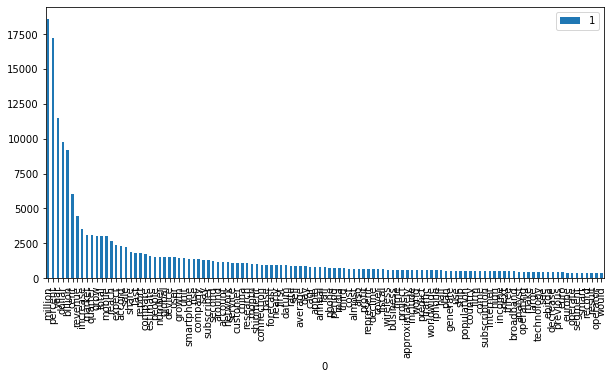

In [ ]:
# visualization of the most common words
value_count=400
df1[df1[1]>value_count].plot.bar(x=0,y=1,figsize=(10,5))

4929


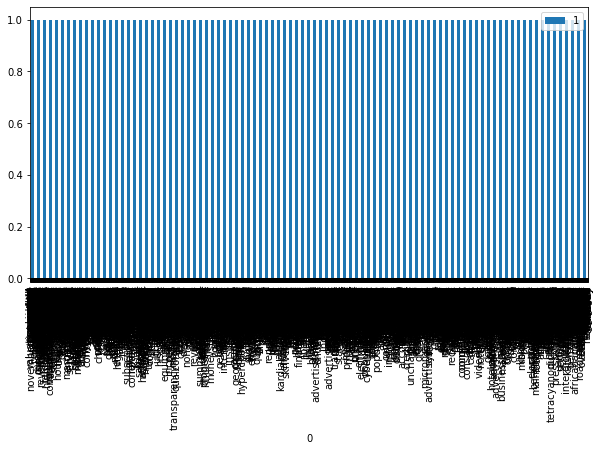

In [ ]:
# visualization of the most rare words
print(df1[df1[1]<2].shape[0])
df1[df1[1]<2].plot.bar(x=0,y=1,figsize=(10,5))

In [ ]:
# generating a bag of words.
#max_features=1500, how many terms we take into account
#min_df=5, if the word occurs less number of times we ignore it.
#max_df=0.7 upper threshold. if a term appears in a larger percentage of the documents then ignore it
count_vect = CountVectorizer(max_features=1500, min_df=5, max_df=0.6)
bow = count_vect.fit_transform(df['Clean_sentence'].values)
bow.shape

(28942, 1500)

In [ ]:
bow

<28942x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 247665 stored elements in Compressed Sparse Row format>

In [ ]:
print(bow)

  (0, 438)	1
  (0, 1155)	1
  (0, 641)	1
  (0, 1157)	1
  (0, 1135)	1
  (0, 760)	1
  (0, 1068)	1
  (0, 137)	2
  (0, 1497)	1
  (0, 373)	1
  (0, 1147)	1
  (0, 964)	1
  (0, 1012)	1
  (0, 1491)	1
  (1, 964)	2
  (1, 1491)	2
  (1, 807)	1
  (1, 599)	1
  (1, 883)	1
  (1, 1358)	1
  (1, 1493)	1
  (2, 777)	1
  (2, 105)	1
  (2, 1426)	1
  (2, 453)	1
  :	:
  (28938, 1390)	1
  (28938, 1057)	1
  (28938, 831)	1
  (28939, 842)	1
  (28939, 578)	1
  (28939, 846)	2
  (28939, 972)	1
  (28939, 5)	1
  (28939, 1417)	1
  (28939, 603)	1
  (28939, 916)	1
  (28939, 34)	1
  (28939, 94)	1
  (28940, 137)	2
  (28940, 1485)	1
  (28940, 439)	1
  (28940, 360)	1
  (28940, 441)	1
  (28940, 879)	1
  (28940, 267)	1
  (28940, 1365)	1
  (28941, 842)	1
  (28941, 711)	1
  (28941, 1318)	1
  (28941, 263)	1


In [ ]:
# to see what words are in the bag of words
terms = count_vect.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#first 10 columns generated by BOW
terms[1440:]

['virtual',
 'visitors',
 'visits',
 'vivo',
 'vodafone',
 'voice',
 'voip',
 'volte',
 'volume',
 'volumes',
 'votes',
 'wall',
 'waste',
 'watch',
 'water',
 'wearable',
 'wearables',
 'website',
 'wednesday',
 'week',
 'weeks',
 'well',
 'went',
 'western',
 'whatsapp',
 'whereas',
 'whole',
 'whopping',
 'wide',
 'wifi',
 'wimax',
 'windows',
 'wire',
 'wired',
 'wireless',
 'wireline',
 'within',
 'without',
 'witnessed',
 'wlan',
 'women',
 'work',
 'workers',
 'workforce',
 'working',
 'world',
 'worldwide',
 'worth',
 'would',
 'write',
 'xiaomi',
 'year',
 'yearly',
 'years',
 'yet',
 'york',
 'youtube',
 'yuan',
 'zero',
 'zigbee']

In [ ]:
bow

<28942x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 247665 stored elements in Compressed Sparse Row format>

## Tf-Idf

In [ ]:
count_vect = CountVectorizer()

In [ ]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()

In [ ]:
X

['chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year',
 'cognitive market grow percent percent year year next three year',
 'look autonomous vehicle example latency millisecond mean datum share car travel mile hour millimeter',
 'chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year',
 'fiscal expect number grow percent year year basis',
 'nvidia automotive revenue double dollar million fiscal dollar million fiscal',
 'game console add fiscal nvidia tegra revenue rise almost threefold dollar million fiscal dollar billion fiscal',
 'back fiscal nvidia earn percent revenue dollar million licensing',
 'moreover expect outperform market even wsts world semiconductor trade statistic expect global semiconductor revenue fall percent',
 'ericsson report estimate billion subscription globally account percent mobile subscription time',
 'grow percent year year fiscal',
 'fund invest p

In [ ]:
X_train_counts = count_vect.fit_transform(X)
X_train_counts.shape

(28942, 11817)

In [ ]:
# of non-zero elements in the discharged matrix
X_train_counts.nnz

291087

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(28942, 11817)

In [ ]:
# stores the tfidf representation of our texts
X_train_tfidf

<28942x11817 sparse matrix of type '<class 'numpy.float64'>'
	with 291087 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer = TfidfVectorizer(stop_words={'english'})
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
terms1 = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# you can see the list of terms that were sampled
terms1[5:30]

['aaron',
 'aarp',
 'aasb',
 'aayog',
 'abandon',
 'abatement',
 'abbasi',
 'abdelkader',
 'abdominal',
 'abdullah',
 'aberdeen',
 'ability',
 'abiresearch',
 'abkhazia',
 'able',
 'abloy',
 'abnormal',
 'abnormality',
 'aboard',
 'abode',
 'abound',
 'abpa',
 'abpu',
 'abrahamsen',
 'abramsky']

In [ ]:
tfidf_transformer

TfidfTransformer()

## Word2Vec  
Векторизация текстов на основе w2v от gensim.

In [ ]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()

In [ ]:

w2v_model=gensim.models.Word2Vec(X, size=200, 
                                 workers=4,
                                 window=5,# context window
                                   min_count=2)

In [ ]:
import numpy as np
sent_vectors = []; 
for sent in X: 
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(28942, 200)

In [ ]:
sent_vectors[1]

array([ 0.07476392, -0.02244824, -0.05478881,  0.03815947,  0.06008934,
       -0.01376735, -0.05818202,  0.02438096, -0.10805044,  0.04816408,
       -0.05461179, -0.06260673,  0.0823373 ,  0.07895495,  0.01229386,
        0.0638306 ,  0.08851972, -0.06981143,  0.07403269, -0.05801715,
       -0.05896676,  0.00112413, -0.10219344, -0.12732107,  0.10285987,
        0.07219904,  0.03016983, -0.04436672,  0.01113393,  0.04879018,
        0.00975812, -0.0131257 , -0.086815  ,  0.01499455,  0.03471753,
       -0.0637378 , -0.13109312,  0.08374783,  0.06013121,  0.1319957 ,
       -0.05112534, -0.0628845 , -0.0954419 , -0.05481373,  0.0869649 ,
       -0.10503787,  0.01942411,  0.01732888, -0.01454483,  0.07594629,
        0.05246094,  0.0784767 ,  0.03994747,  0.02423201, -0.10261335,
       -0.07272468,  0.02324017, -0.00688664,  0.02002023, -0.02402381,
       -0.03621679, -0.02931103,  0.03193157,  0.03092893,  0.17505578,
       -0.04650367,  0.01169872, -0.06016731,  0.01138485, -0.02

##Hugging face(BERT)

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# I chose the all-MiniLM-L6-v2 semantic core. In fact, on HaggingFace, all 
# semantic kernels have similar parameters. This works faster.
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()
corpus_embeddings = embedder.encode(X, show_progress_bar=True, batch_size=1)

Batches:   0%|          | 0/28942 [00:00<?, ?it/s]

In [ ]:
corpus_embeddings

array([[ 0.05959082, -0.02219998,  0.02948869, ..., -0.05612655,
         0.08812764,  0.01353669],
       [ 0.08218512, -0.05739317, -0.0454534 , ..., -0.01988084,
        -0.026901  ,  0.08722441],
       [ 0.0283787 , -0.05293951, -0.02896568, ...,  0.01958731,
        -0.02877351, -0.00046731],
       ...,
       [-0.02460488,  0.06306286, -0.03477938, ..., -0.07036574,
        -0.06622984, -0.04928489],
       [ 0.01940226, -0.03306866,  0.00711766, ..., -0.05866373,
         0.01911806, -0.02725432],
       [-0.02160954,  0.01859156, -0.05022541, ..., -0.06426147,
        -0.00793428,  0.01774818]], dtype=float32)

# Clustering

Clustering. Conducted by 3 methods (KMeans, DBSCAN, AgglomerativeClustering), for each representation of embeddings(word2vec,tfidf,bert,bag_of_words).  
Wherever possible, there is an analysis of the parameters, but not a complete search

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [ ]:
import gc
from matplotlib import cm

In [ ]:
#Further clustering will be presented in approximately the same way:
#Clustering and adding labels with a new column in the dataset.  
#Column name is **embedding method*_*algorithm clustering algorithm*_*algorithm parameters


100%|██████████| 8/8 [01:04<00:00,  8.02s/it]


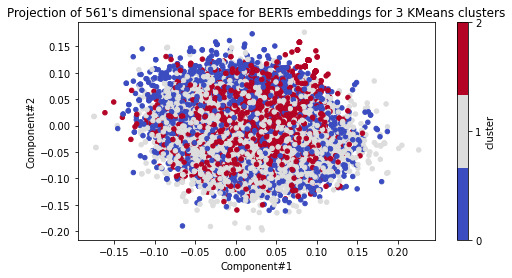

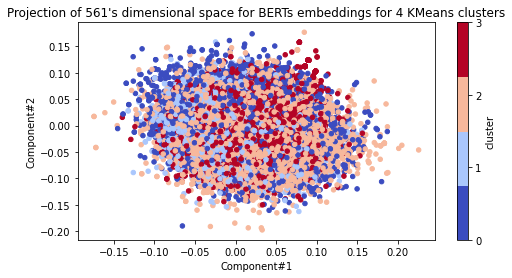

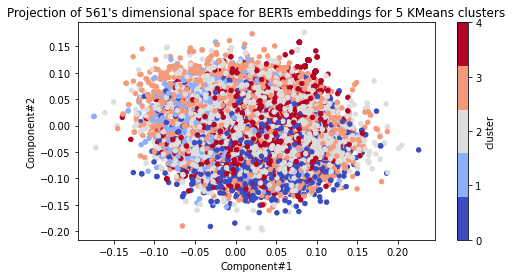

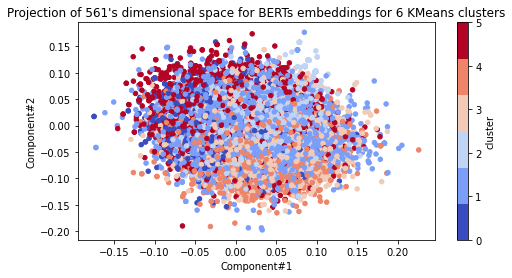

In [ ]:
#For illustration, we plot the dependence of the sum of squares of distances between an element and 
#of its cluster center from the number of clusters.
#The distances also depend on the method of embedding (different scales)
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(corpus_embeddings)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'Bert_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()


    if (k>2 and k<7):
      plt.figure(figsize=(8,4))
      plt.scatter(corpus_embeddings[:,0], corpus_embeddings[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', k));
      plt.title('Projection of dimensional space for BERTs embeddings for {} KMeans clusters'.format(k))
      plt.xlabel('Component#1')
      plt.ylabel('Component#2')
      plt.colorbar(ticks=[i for i in range(k)], label='cluster')
plt.show()



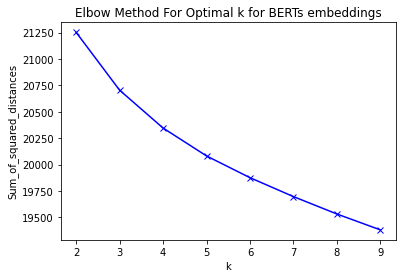

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for BERTs embeddings')
plt.show()

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

376462

100%|██████████| 8/8 [00:59<00:00,  7.38s/it]


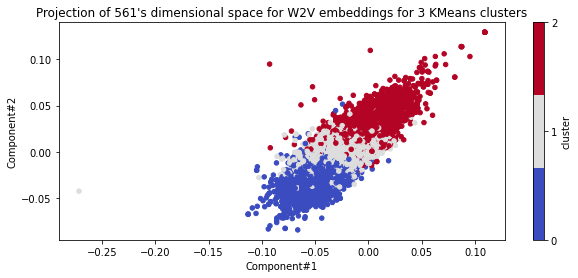

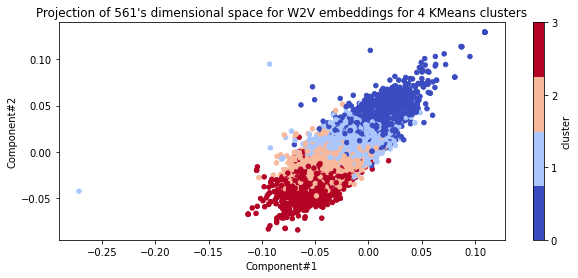

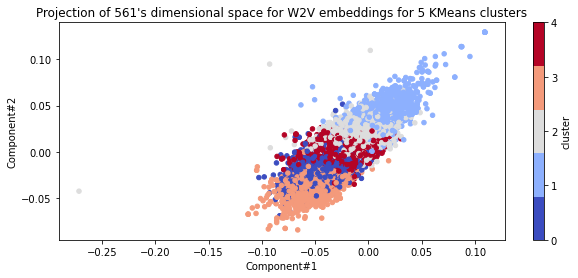

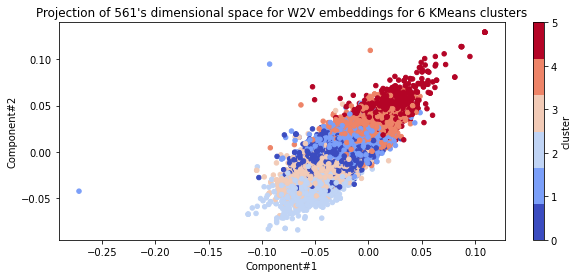

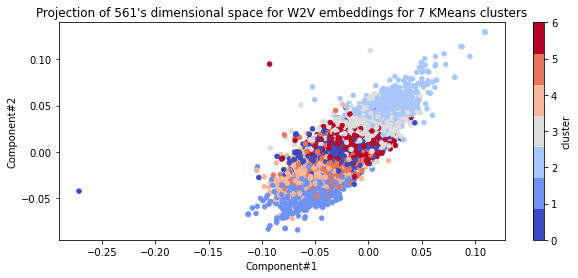

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(sent_vectors)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'w2v_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
    if (k>2 and k<8):
      plt.figure(figsize=(10, 4))
      plt.scatter(sent_vectors[:,0], sent_vectors[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', k));
      plt.title('Projection of dimensional space for W2V embeddings for {} KMeans clusters'.format(k))
      plt.xlabel('Component#1')
      plt.ylabel('Component#2')
      plt.colorbar(ticks=[i for i in range(k)], label='cluster')
plt.show()


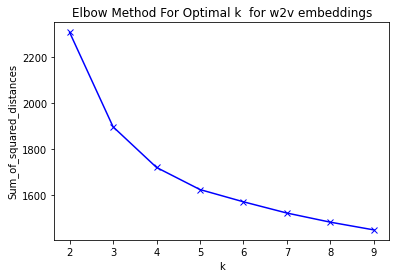

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k  for w2v embeddings')
plt.show()

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

608012

In [ ]:

Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(bow)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'bow_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()




100%|██████████| 8/8 [00:24<00:00,  3.09s/it]


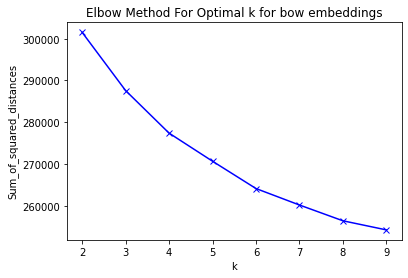

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for bow embeddings')
plt.show()

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

839550

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X_train_tfidf)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'tfidf_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()




100%|██████████| 8/8 [01:12<00:00,  9.08s/it]


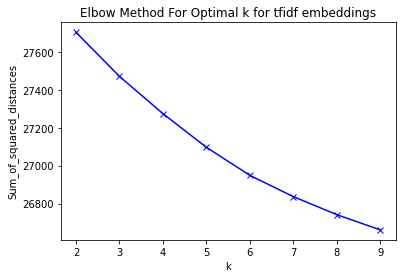

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for tfidf embeddings')
plt.show()

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

1071100

In [ ]:
n_clusters=5

In [ ]:
# a small example of getting popular words in clusters. monographs
km = KMeans(n_clusters=n_clusters, max_iter=200, n_init=10)
km = km.fit(corpus_embeddings) #bert
Sum_of_squared_distances.append(km.inertia_)

In [ ]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 0: abridge
 agenda
 accelerate
 africa
 airframe
 airbag
 aiming
 abatement
 advertisementthe
 alienware
Cluster 1: abridge
 adjust
 aerohive
 allege
 africa
 adler
 accelerate
 african
 afterwards
 achieve
Cluster 2: airbag
 accelerate
 abridge
 acceleration
 affops
 administration
 allege
 aidsvu
 across
 abroad
Cluster 3: abridge
 afterwards
 allege
 aerohive
 african
 acceleration
 adjust
 abroad
 accelerate
 aldebaran
Cluster 4: abridge
 allege
 adjust
 african
 aid
 across
 airbag
 achieve
 affordability
 accelerate


## DBScan

In [ ]:
#Count the distance between minPts closest neighbors.
#
minPts = 100 # number of nearest neighbors to which we count the distance
def lower_bound(nums, target): 
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def computenearestneighbour(x, data): 
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) 
        if(len(dists) == minPts and dists[minPts-1] > dist): 
            l = int(lower_bound(dists, dist)) 
            if l < minPts and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[minPts-1] 

In [ ]:
rows=round(sent_vectors.shape[0]*0.1,0)#0.1 is the percentage of points for which we calculate the distance to the nearest neighbors
rows = int(rows)
rows

2894

In [ ]:
#For each object the distance from it to the closest min_pts is counted.
#is done for optimal selection of the eps parameter in DBSCAN. 
#The value should be taken at less than y where the graph starts to grow sharply

neigh = []
for val in sent_vectors[:rows]:
    neigh.append( computenearestneighbour(val, sent_vectors[:rows]) ) # rows can be replaced by a smaller number
neigh.sort()

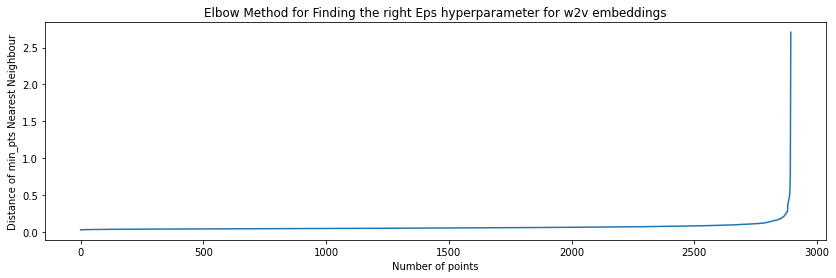

In [ ]:
# dependence of the distance to min_pts of the nearest neighbors on the number of counted points
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for w2v embeddings")
plt.plot([x for x in range(len(neigh))], neigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of min_pts Nearest Neighbour")
plt.show()

In [ ]:
gc.collect()

0

In [ ]:
# clustering and immediately adding dataframe labels
# vr_ar_classification (eps = 0.1, min_samples = 100, metric='cosine', n_jobs=-1)
# vr_ar_classification (eps = 0.4, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.25, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.25, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(sent_vectors)
labels = model.labels_
print(set(labels))


{0, -1}


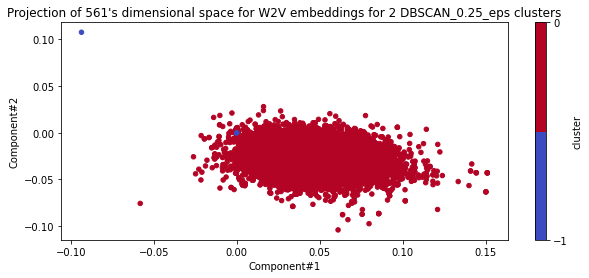

In [ ]:
plt.figure(figsize=(10, 4))
plt.scatter(sent_vectors[:,0], sent_vectors[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', 2));
plt.title('Projection of dimensional space for W2V embeddings for {} DBSCAN_0.25_eps clusters'.format(2))
plt.xlabel('Component#1')
plt.ylabel('Component#2')
plt.colorbar(ticks=[i for i in [-1,0]], label='cluster')
plt.show()

In [ ]:
column_name=f'w2v_embed_DBSCAN_0.25_eps'
df[column_name]=labels.tolist()

In [ ]:
gc.collect()

296

In [ ]:
# vr_ar_classification (eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.2, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(sent_vectors)
labels = model.labels_
print(set(labels)) # list of classes


{0, -1}


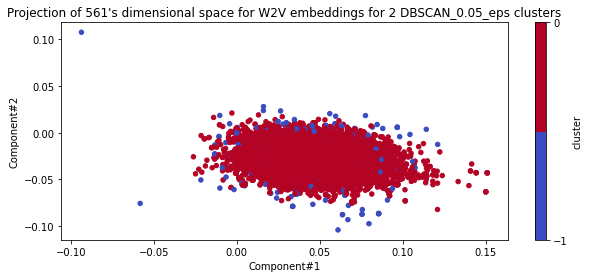

In [ ]:
plt.figure(figsize=(10, 4))
plt.scatter(sent_vectors[:,0], sent_vectors[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', 2));
plt.title('Projection of dimensional space for W2V embeddings for {} DBSCAN_0.05_eps clusters'.format(2))
plt.xlabel('Component#1')
plt.ylabel('Component#2')
plt.colorbar(ticks=[i for i in [-1,0]], label='cluster')
plt.show()

In [ ]:
column_name=f'w2v_embed_DBSCAN_0.05_eps'
df[column_name]=labels.tolist()

In [ ]:
df.to_excel(out_path)

In [ ]:
bow_ar= bow.toarray() # from a sparse matrix to a regular array for the algorithm to work

In [ ]:
neigh = []
for val in bow_ar[:rows]:
    neigh.append( computenearestneighbour(val, bow_ar[:rows]) )
neigh.sort()

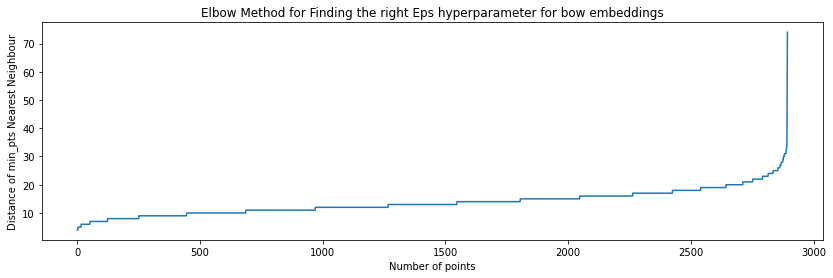

In [ ]:
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for bow embeddings")
plt.plot([x for x in range(len(neigh))], neigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of min_pts Nearest Neighbour")
plt.show()

In [ ]:
gc.collect()

20533

In [ ]:
# vr_ar_classification (eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.9, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.9, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, -1}


In [ ]:
column_name=f'bow_embed_DBSCAN_0.9_eps'
df[column_name]=labels.tolist()

In [ ]:
# vr_ar_classification (eps = 0.4, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.4, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, -1}


In [ ]:
column_name=f'bow_embed_DBSCAN_0.5_eps'
df[column_name]=labels.tolist()

In [ ]:
gc.collect()

7918

In [ ]:
# vr_ar_classification (eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [ ]:
column_name=f'bow_embed_DBSCAN_0.35_eps'
df[column_name]=labels.tolist()

In [ ]:
gc.collect()

4042

In [ ]:
df.to_excel(out_path)

In [ ]:
# Computing the min_pts nearest neighbour distance of some point the dataset:
neigh = []
for val in corpus_embeddings[:rows]:
    neigh.append( computenearestneighbour(val, corpus_embeddings[:rows]) )
neigh.sort()

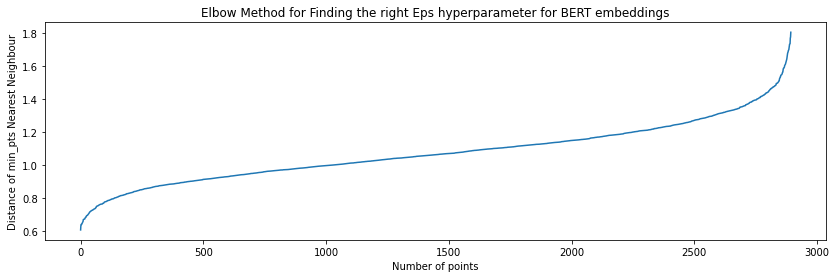

In [ ]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for BERT embeddings")
plt.plot([x for x in range(len(neigh))], neigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of min_pts Nearest Neighbour")
plt.show()

In [ ]:
# vr_ar_classification (eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(corpus_embeddings)
labels = model.labels_
print(set(labels))


{0, -1}


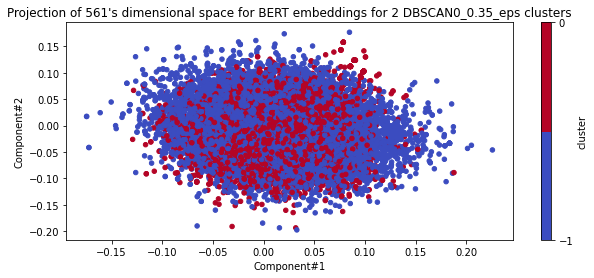

In [ ]:
plt.figure(figsize=(10, 4))
plt.scatter(corpus_embeddings[:,0], corpus_embeddings[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', 2));
plt.title('Projection of dimensional space for BERT embeddings for {} DBSCAN0_0.35_eps clusters'.format(2))
plt.xlabel('Component#1')
plt.ylabel('Component#2')
plt.colorbar(ticks=[i for i in [-1,0]], label='cluster')
plt.show()

In [ ]:
column_name=f'BERT_embed_DBSCAN_0.35_eps'
df[column_name]=labels.tolist()

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

6816

In [ ]:
# vr_ar_classification (eps = 0.4, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.2, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.36, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.2, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(corpus_embeddings)
labels = model.labels_
print(set(labels))


{0, 1, -1}


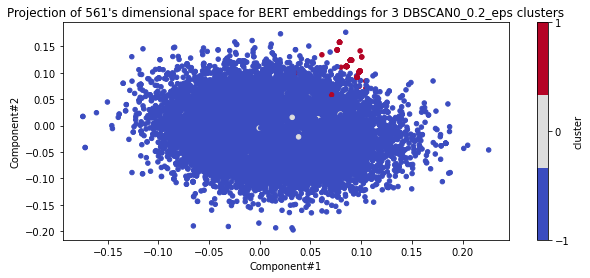

In [ ]:
plt.figure(figsize=(10, 4))
plt.scatter(corpus_embeddings[:,0], corpus_embeddings[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', 3));
plt.title('Projection of dimensional space for BERT embeddings for {} DBSCAN0_0.2_eps clusters'.format(3))
plt.xlabel('Component#1')
plt.ylabel('Component#2')
plt.colorbar(ticks=[i for i in [-1,0,1]], label='cluster')
plt.show()

In [ ]:
column_name=f'BERT_embed_DBSCAN_0.2_eps'
df[column_name]=labels.tolist()

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

4392

In [ ]:
X_train_tfidf_arr=X_train_tfidf.toarray()
X_train_tfidf_arr.shape

(28942, 11817)

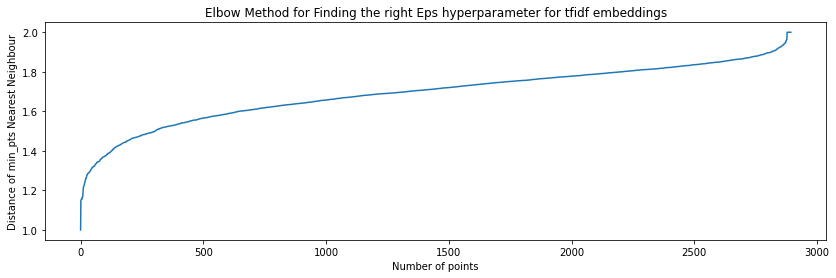

In [ ]:

neigh = []
for val in X_train_tfidf_arr[:rows]:
    neigh.append( computenearestneighbour(val, X_train_tfidf_arr[:rows]) )
neigh.sort()
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for tfidf embeddings")
plt.plot([x for x in range(len(neigh))], neigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of min_pts Nearest Neighbour")
plt.show()

In [ ]:
# vr_ar_classification (eps = 0.8, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.7, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.7, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(X_train_tfidf_arr)
labels = model.labels_
print(set(labels))


{0, -1}


In [ ]:
column_name=f'tfidf_embed_DBSCAN_0.7_eps'
df[column_name]=labels.tolist()

In [ ]:
gc.collect()

7138

In [ ]:
# vr_ar_classification (eps = 0.7, min_samples = 100, metric='cosine', n_jobs=-1)
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
#neur_ai_classification DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(X_train_tfidf_arr)
labels = model.labels_
print(set(labels))


{0, -1}


In [ ]:
column_name=f'tfidf_embed_DBSCAN_0.6_eps'
df[column_name]=labels.tolist()

In [ ]:
gc.collect()

140

In [ ]:
df.to_excel(out_path)

## Clustering Hierarchical
works for a very long time!

100%|██████████| 3/3 [07:48<00:00, 156.20s/it]


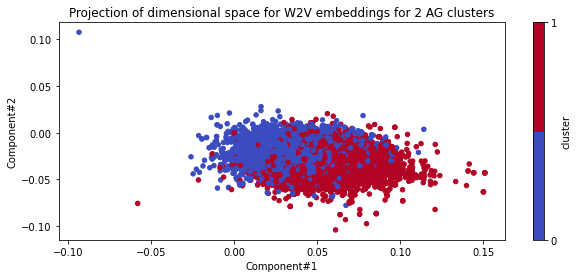

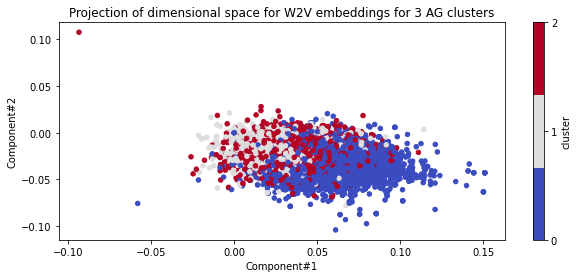

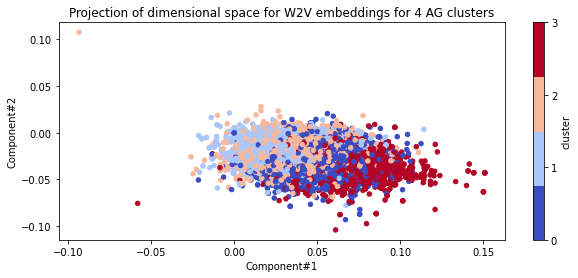

In [ ]:
K = range(2,5)
for k in tqdm.tqdm(K):

    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(sent_vectors)
    column_name=f'w2v_embed_Agg_{k}_clusters'
    labels = Agg
    df[column_name]=labels.tolist()

    plt.figure(figsize=(10, 4))
    plt.scatter(sent_vectors[:,0], sent_vectors[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', k));
    plt.title('Projection of dimensional space for W2V embeddings for {} AG clusters'.format(k))
    plt.xlabel('Component#1')
    plt.ylabel('Component#2')
    plt.colorbar(ticks=[i for i in range(k)], label='cluster')
plt.show()




In [ ]:
df.to_excel(out_path)

In [ ]:
K = range(2,5)
for k in tqdm.tqdm(K):

    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(bow_ar)
    column_name=f'bow_embed_Agg_{k}_clusters'
    labels = Agg
    df[column_name]=labels.tolist()

100%|██████████| 3/3 [36:20<00:00, 726.87s/it]


In [ ]:
df.to_excel(out_path)

100%|██████████| 3/3 [11:05<00:00, 221.79s/it]


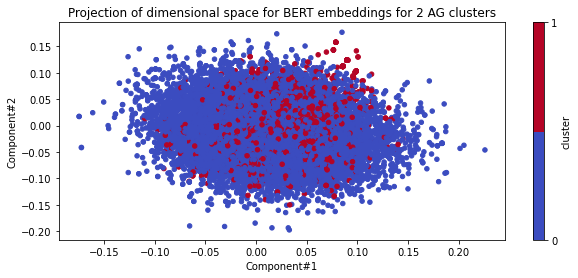

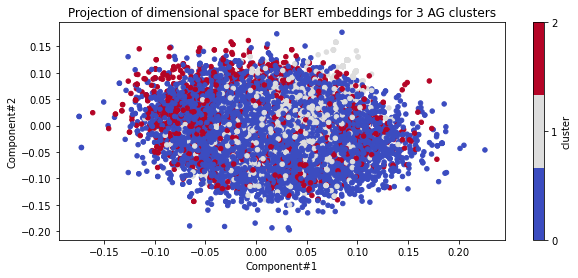

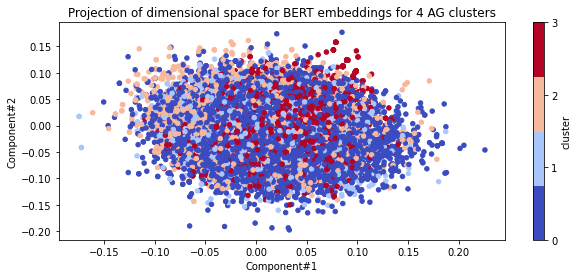

In [ ]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(corpus_embeddings)
    column_name=f'bert_embed_Agg_{k}_clusters'
    labels = Agg
    df[column_name]=labels.tolist()

    plt.figure(figsize=(10, 4))
    plt.scatter(corpus_embeddings[:,0], corpus_embeddings[:,1], c=labels, s=20, cmap=plt.cm.get_cmap('coolwarm', k));
    plt.title('Projection of dimensional space for BERT embeddings for {} AG clusters'.format(k))
    plt.xlabel('Component#1')
    plt.ylabel('Component#2')
    plt.colorbar(ticks=[i for i in  range(k)], label='cluster')
plt.show()

In [ ]:
df.to_excel(out_path)

In [ ]:
# X_train_tfidf_arr In general, everything takes a long time to work. And this particular cell takes a VERY long time. We will not use it further! 
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(X_train_tfidf_arr)
    column_name=f'tfidf_embed_Agg_{k}_clusters'
    labels = Agg
    df[column_name]=labels.tolist()

In [ ]:
df.to_excel(out_path)

## Searching best result

In [ ]:
df1=pd.read_excel('besprovodnaya_svyaz__0_95_classification_output.xlsx')

###Good claster

In [ ]:
x=1 # 1 - target, 0.2 - trash
df1[['sentence','Bert_embed_K_means_3_clusters']][df1.Bert_embed_K_means_3_clusters==x] 

,sentence,Bert_embed_K_means_3_clusters
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,1
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,1
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,1
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",1
5,So Nvidia’s automotive revenue has doubled from $320 million in fiscal 2016 to $640 million in fiscal 2019.,1
6,Game consoles were added in fiscal 2017.Nvidia’s Tegra revenue rose almost threefold from $559 million in fiscal 2016 to $1.54 billion in fiscal 2019.,1
7,"Back in fiscal 2016, Nvidia earned 5% of its revenue—or $264 million—from licensing.",1
8,"Moreover, it’s expected to outperform the market, even in 2019.The WSTS (World Semiconductor Trade Statistics) expects global semiconductor revenue to fall 12.8% in 2019.",1
10,It grew 11% year-over-year in fiscal 2017 and 2018.,1
12,"Also, analysts expect the revenue to fall by 0.6% YoY to $32.19 billion in fiscal 2020, and by 0.6% YoY to $32.00 billion in fiscal 2021.",1


###Good clustering, but not good for us

Here we see 3 clear clusters about the state of the market, but the problem is that all 3 clusters contain both target and non-target texts, which is very bad and does not give us any information

In [ ]:
y=1 # -1 is more about market conditions rather than growth itself, 0 is about growth, 1 is more about decline
df1[['sentence','BERT_embed_DBSCAN_0.2_eps']][df1['BERT_embed_DBSCAN_0.2_eps']==y] 

,sentence,BERT_embed_DBSCAN_0.2_eps
3386,"were NIS 47 million (US$ 12 million) in Q4 2016, a decrease of 16% from NIS 56 million in Q4 2015.",1
3392,"Annual in 2016 totaled NIS 2,752 million (US$ 716 million), a decrease of 8% from NIS 2,992 million in 2015.",1
3393,"In 2016, were NIS 3,544 million (US$ 922 million), a decrease of 14% from NIS 4,111 million in 2015.",1
3395,"in 2016 were NIS 105 million (US$ 27 million), a decrease of 27% compared with NIS 143 million in 2015.",1
3396,"in Q4 2016 totaled NIS 498 million (US$ 130 million), a decrease of 9% from NIS 550 million in Q4 2015.",1
3397,"totaled NIS 45 million (US$ 12 million) in 2016, compared to NIS 47 million in 2015, a decrease of 4%, mainly reflecting a decrease in income from the unwinding of trade receivables.",1
3400,"in 2016 totaled NIS 834 million (US$ 217 million), a decrease of 5% from NIS 876 million in 2015.",1
3401,"For Q4 2016, operating profit was NIS 8 million (US$ 2 million), compared with operating loss of NIS 48 million in Q4 2015.",1
3403,"For Q4 2016, finance costs, net were NIS 23 million (US$ 6 million), a decrease of 41% compared with NIS 39 million in Q4 2015.",1
3404,"in 2016 totaled NIS 866 million (US$ 225 million), a decrease of 4% from NIS 906 million in 2015.",1


###poor clustering

In [ ]:
z=1 #all clusters are mixed but 1 cluster has the largest number of target texts
df1[['sentence','bow_embed_K_means_3_clusters']][df1.bow_embed_K_means_3_clusters==z] 

,sentence,bow_embed_K_means_3_clusters
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,1
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,1
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,1
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",1
10,It grew 11% year-over-year in fiscal 2017 and 2018.,1
11,"The fund invests 11.8% of its portfolio in Intel, 5.8% in Nvidia, and 4.8% in AMD.",1
12,"Also, analysts expect the revenue to fall by 0.6% YoY to $32.19 billion in fiscal 2020, and by 0.6% YoY to $32.00 billion in fiscal 2021.",1
13,"Analysts expect Sprint’s revenues to fall by 3.6% YoY (year-over-year) to $32.38 billion in fiscal 2019, which ends in March.",1
15,"This jump came as Datacenter revenue rose 145%, 133%, and 50% in fiscal 2017, 2018, and 2019.",1
19,"But as we near the end of 2019, Nvidia is guiding for fiscal 2020 revenue of $10.8 billion, down 8% year-over-year.",1


In [ ]:
v=3 
df1[['sentence','w2v_embed_K_means_6_clusters']][df1.w2v_embed_K_means_6_clusters==v] 

,sentence,w2v_embed_K_means_6_clusters
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,3
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",3
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,3
7,"Back in fiscal 2016, Nvidia earned 5% of its revenue—or $264 million—from licensing.",3
9,"The Ericsson Report 2019 estimates 2.6 billion 5G subscriptions globally by 2025, accounting for 29% of all mobile subscriptions at that time.",3
14,"As per a recent study, the internet user base in India has surpassed 500 million devices and is likely to touch 627 million by the end of 2020.",3
18,"AirPods sales almost doubled in 2019 to $6 billion and are expected to generate $15 billion in revenue in 2020, Bernstein analyst Toni Saccconaghi recently wrote in a note reported by CNBC.",3
19,"But as we near the end of 2019, Nvidia is guiding for fiscal 2020 revenue of $10.8 billion, down 8% year-over-year.",3
27,"AT&T reported revenue of $134.4 billion in the first nine months of 2019 compared to $122.8 billion during the same period in 2018, reflecting 9.5% YoY growth.",3
29,"By 2022, over 700 million people are expected to have a smartphone in India, and over a billion devices will be sold over the next four-five years, he said.",3


at this stage we can conclude that about the best number of clusters will be 2-3, because 2 clusters are unlikely to show a clear division between the desired and unnecessary texts, and more than 3 will give already garbage clusters, which lie both targeted and non-target texts and in the future will be a problem with the search n-gramm

In [ ]:
#df2=pd.read_excel('vr_ar_classification_output.xlsx')
#claster=0 # целевой, -1,1 мусорные
#df2[['sentence','bow_embed_DBSCAN_0.4_eps']][df2['bow_embed_DBSCAN_0.4_eps']==claster] 
#claster=2 # целевой, 0,1,3 - мусорные
#df2[['sentence','Bert_embed_K_means_4_clusters']][df2['Bert_embed_K_means_4_clusters']==claster]

In [ ]:
#df3=pd.read_excel('data/neur_ai_classification_output.xlsx')  
#claster = 0 # 0,2 - целевые, -1 и 1 мусорные
#df3[['sentence','BERT_embed_DBSCAN_0.35_eps']][df3['BERT_embed_DBSCAN_0.35_eps']==claster]

## Search n-grams

In [ ]:
df=pd.read_excel('besprovodnaya_svyaz__0_95_classification_output.xlsx')

In [ ]:
df=df.drop(columns=['Bert_embed_K_means_2_clusters',
       'Bert_embed_K_means_4_clusters',
       'Bert_embed_K_means_5_clusters', 'Bert_embed_K_means_6_clusters',
       'Bert_embed_K_means_7_clusters', 'Bert_embed_K_means_8_clusters',
       'Bert_embed_K_means_9_clusters', 'w2v_embed_K_means_2_clusters',
       'w2v_embed_K_means_3_clusters', 'w2v_embed_K_means_4_clusters',
       'w2v_embed_K_means_5_clusters', 'w2v_embed_K_means_6_clusters',
       'w2v_embed_K_means_7_clusters', 'w2v_embed_K_means_8_clusters',
       'w2v_embed_K_means_9_clusters', 'bow_embed_K_means_2_clusters',
       'bow_embed_K_means_3_clusters', 'bow_embed_K_means_4_clusters',
       'bow_embed_K_means_5_clusters', 'bow_embed_K_means_6_clusters',
       'bow_embed_K_means_7_clusters', 'bow_embed_K_means_8_clusters',
       'bow_embed_K_means_9_clusters', 'tfidf_embed_K_means_2_clusters',
       'tfidf_embed_K_means_3_clusters', 'tfidf_embed_K_means_4_clusters',
       'tfidf_embed_K_means_5_clusters', 'tfidf_embed_K_means_6_clusters',
       'tfidf_embed_K_means_7_clusters', 'tfidf_embed_K_means_8_clusters',
       'tfidf_embed_K_means_9_clusters', 'w2v_embed_DBSCAN_0.25_eps',
       'w2v_embed_DBSCAN_0.05_eps', 'bow_embed_DBSCAN_0.9_eps',
       'bow_embed_DBSCAN_0.5_eps', 'bow_embed_DBSCAN_0.35_eps',
       'BERT_embed_DBSCAN_0.25_eps',
       'tfidf_embed_DBSCAN_0.7_eps', 'tfidf_embed_DBSCAN_0.6_eps',
       'w2v_embed_Agg_2_clusters', 'w2v_embed_Agg_3_clusters',
       'w2v_embed_Agg_4_clusters', 'bow_embed_Agg_2_clusters',
       'bow_embed_Agg_3_clusters', 'bow_embed_Agg_4_clusters',
       'bert_embed_Agg_2_clusters', 'bert_embed_Agg_3_clusters',
       'bert_embed_Agg_4_clusters'],axis=1)        
df=df.dropna(axis='index')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28935 entries, 0 to 28941
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Unnamed: 0                     28935 non-null  int64 
 1   sentence                       28935 non-null  object
 2   Clean_sentence                 28935 non-null  object
 3   Clean_sentence_lemm_nltk       28935 non-null  object
 4   Clean_sentence_lemm_spacy      28935 non-null  object
 5   Bert_embed_K_means_3_clusters  28935 non-null  int64 
 6   BERT_embed_DBSCAN_0.2_eps      28935 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.8+ MB


In [ ]:
import statistics


In [ ]:
def search_ngrams(data:list, n_size:int):
    '''
    searches for ngrams of the given length
    data - the list with strings in which we are looking for ngrams
    n_size - size of ngrams
    '''
    n_grams_counter={}
    for sentence in data:
        sentence=sentence.split(' ')
        for word in range(len(sentence)-n_size+1):
            n_gramma=sentence[word:word+n_size]
            n_gramma=' '.join([w for w in n_gramma])
            if n_gramma in n_grams_counter.keys():
                n_grams_counter[n_gramma]+=1
            else:
                n_grams_counter[n_gramma]=1
    return n_grams_counter

In [ ]:
# get the target data and the rest
X_Kmean_aim = df.Clean_sentence_lemm_spacy[df.Bert_embed_K_means_3_clusters==1].values.tolist()
X_Kmean_other = df.Clean_sentence_lemm_spacy[df.Bert_embed_K_means_3_clusters!=1].values.tolist()

In [ ]:
def n_gram_analitic(aim_dictionary:dict,other_dictionary:list,min_count=1):
    '''
    calculates n-grams that occur only in the target texts
    calculate numerical characteristics of n-grams
    we calculate n-grams which are typical only for non-target texts
    everywhere the minimal frequency of n-grams is taken into account in order not to take into account "garbage" n-grams
    which occur only once
    '''
    # count n-grams unique to target texts first
    unic_aim_ngrams=set(aim_dictionary.keys()).difference(set(other_dictionary.keys()))
    unic_aim_ngrams={key:value for (key,value) in aim_dictionary.items() if key in unic_aim_ngrams and value >min_count}
    unic_aim_ngrams = sorted(unic_aim_ngrams.items(), key=lambda item: item[1],reverse=True)
    unic_aim_ngrams=dict(unic_aim_ngrams)
    print(f'found {len(unic_aim_ngrams)} unique n-grams in the target texts')
    all_values = unic_aim_ngrams.values()
    max_value = max(all_values)
    min_value = min(all_values)
    mean_value = sum(all_values)/len(all_values)
    mode_value = statistics.mode(all_values)
    st_dev = statistics.pstdev(all_values)
    print(f'maximum frequency of mention of the n-gram in the target texts {max_value}')
    print(f'minimum frequency of mention of the n-gram in the target texts {min_value}')
    print(f'average frequency of n-gram mentions in the target texts {mean_value}')
    print(f'modal frequency of n-gram mention in the target texts {mode_value}')
    print(f'standard deviation of the frequency of n-gram mention in the target texts {st_dev}')
    plt.plot(sorted(all_values,reverse=True))
    plt.ylabel("the number of mentions of the n-gram in the target texts")
    print('\n\n')
    # count n-grams that should not be in the target texts
    unic_other_ngram=set(other_dictionary.keys()).difference(set(aim_dictionary.keys()))
    unic_other_ngram={key:value for (key,value) in other_dictionary.items() if key in unic_other_ngram and value >min_count}
    unic_other_ngram = sorted(unic_other_ngram.items(), key=lambda item: item[1],reverse=True)
    unic_other_ngram=dict(unic_other_ngram)
    print(f'found {len(unic_other_ngram)} unique n-grams in non-target texts')
    all_values = unic_other_ngram.values()
    max_value = max(all_values)
    min_value = min(all_values)
    mean_value = sum(all_values)/len(all_values)
    mode_value = statistics.mode(all_values)
    st_dev = statistics.pstdev(all_values)
    print(f'maximum frequency of n-gram mention in non-target texts {max_value}')
    print(f'minimum frequency of n-gram mention in non-target texts {min_value}')
    print(f'average frequency of n-gram mentions in non-target texts {mean_value}')
    print(f'modal frequency of n-gram mention in non-target texts {mode_value}')
    print(f'standard deviation of the frequency of n-gram mention in non-target texts {st_dev}')
    
    return unic_aim_ngrams,unic_other_ngram

In [ ]:
# set the minimum frequency of the ngram
min_count=2

found 1915 unique n-grams in the target texts
maximum frequency of mention of the n-gram in the target texts 131
minimum frequency of mention of the n-gram in the target texts 3
average frequency of n-gram mentions in the target texts 4.8877284595300265
modal frequency of n-gram mention in the target texts 3
standard deviation of the frequency of n-gram mention in the target texts 4.826864640245



found 9483 unique n-grams in non-target texts
maximum frequency of n-gram mention in non-target texts 151
minimum frequency of n-gram mention in non-target texts 3
average frequency of n-gram mentions in non-target texts 5.400189813350206
modal frequency of n-gram mention in non-target texts 3
standard deviation of the frequency of n-gram mention in non-target texts 5.952448568319376


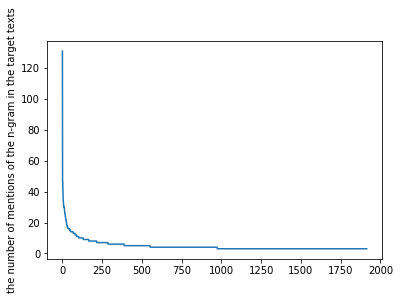

In [ ]:
bigrams_X_Kmean_aim=search_ngrams(X_Kmean_aim,2)
bigrams_X_Kmean_other=search_ngrams(X_Kmean_other,2)
aim_bigrams,other_bigrams=n_gram_analitic(bigrams_X_Kmean_aim,bigrams_X_Kmean_other,min_count)

In [ ]:
aim_bigrams

{'quarter dollar': 131,
 'gross profit': 46,
 'dollar dilute': 46,
 'revenue second': 42,
 'billion quarter': 39,
 'quarter sale': 34,
 'billion profit': 34,
 'profit increase': 32,
 'sale revenue': 30,
 'ebitda dollar': 30,
 'ebitda grow': 30,
 'segment revenue': 30,
 'compare operate': 30,
 'record dollar': 28,
 'company record': 27,
 'repurchase million': 26,
 'gaap basis': 26,
 'gaap income': 25,
 'cash equivalent': 24,
 'gaap earning': 24,
 'compare revenue': 23,
 'fiscal compare': 22,
 'cash cash': 22,
 'compare profit': 21,
 'million income': 21,
 'fiscal revenue': 20,
 'ebitda decline': 20,
 'income rise': 19,
 'year operating': 18,
 'quarter decrease': 18,
 'grow revenue': 18,
 'revenue stand': 17,
 'expense dollar': 17,
 'expense percent': 17,
 'growth revenue': 17,
 'iphone revenue': 16,
 'earning interest': 16,
 'sequentially percent': 16,
 'fiscal second': 16,
 'currency term': 16,
 'revenue fourth': 16,
 'company repurchase': 16,
 'compare income': 16,
 'adjust operating'

found 3106 unique n-grams in the target texts
maximum frequency of mention of the n-gram in the target texts 127
minimum frequency of mention of the n-gram in the target texts 3
average frequency of n-gram mentions in the target texts 4.907598197037991
modal frequency of n-gram mention in the target texts 3
standard deviation of the frequency of n-gram mention in the target texts 5.7939640607447815



found 9531 unique n-grams in non-target texts
maximum frequency of n-gram mention in non-target texts 220
minimum frequency of n-gram mention in non-target texts 3
average frequency of n-gram mentions in non-target texts 4.2719546742209635
modal frequency of n-gram mention in non-target texts 3
standard deviation of the frequency of n-gram mention in non-target texts 3.6287866988458006


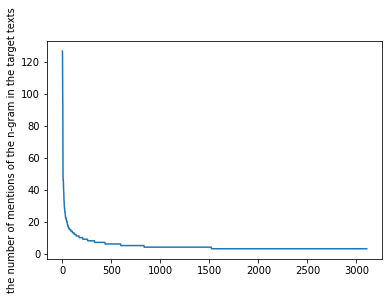

In [ ]:
tergrams_X_Kmean_aim=search_ngrams(X_Kmean_aim,3)
tergrams_X_Kmean_other=search_ngrams(X_Kmean_other,3)
aim_tergrams,other_tergrams=n_gram_analitic(tergrams_X_Kmean_aim,tergrams_X_Kmean_other,min_count)

found 3298 unique n-grams in the target texts
maximum frequency of mention of the n-gram in the target texts 121
minimum frequency of mention of the n-gram in the target texts 3
average frequency of n-gram mentions in the target texts 4.749545178896301
modal frequency of n-gram mention in the target texts 3
standard deviation of the frequency of n-gram mention in the target texts 5.467726700300944



found 7507 unique n-grams in non-target texts
maximum frequency of n-gram mention in non-target texts 38
minimum frequency of n-gram mention in non-target texts 3
average frequency of n-gram mentions in non-target texts 3.741441321433329
modal frequency of n-gram mention in non-target texts 3
standard deviation of the frequency of n-gram mention in non-target texts 1.5346075486413961


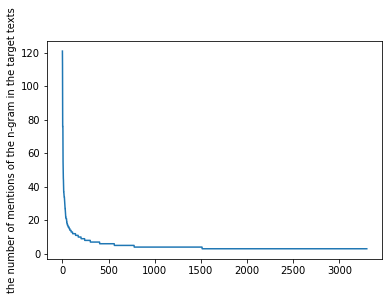

In [ ]:
fourgrams_X_Kmean_aim=search_ngrams(X_Kmean_aim,4)
fourgrams_X_Kmean_other=search_ngrams(X_Kmean_other,4)
aim_fourgrams,other_fourgrams=n_gram_analitic(fourgrams_X_Kmean_aim,fourgrams_X_Kmean_other,min_count)

found 2848 unique n-grams in the target texts
maximum frequency of mention of the n-gram in the target texts 109
minimum frequency of mention of the n-gram in the target texts 3
average frequency of n-gram mentions in the target texts 4.384480337078652
modal frequency of n-gram mention in the target texts 3
standard deviation of the frequency of n-gram mention in the target texts 4.077031875684038



found 6059 unique n-grams in non-target texts
maximum frequency of n-gram mention in non-target texts 17
minimum frequency of n-gram mention in non-target texts 3
average frequency of n-gram mentions in non-target texts 3.5964680640369697
modal frequency of n-gram mention in non-target texts 3
standard deviation of the frequency of n-gram mention in non-target texts 1.122646033830429


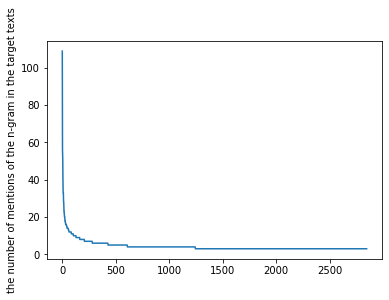

In [ ]:
fivegrams_X_Kmean_aim=search_ngrams(X_Kmean_aim,5)
fivegrams_X_Kmean_other=search_ngrams(X_Kmean_other,5)
aim_fivegrams,other_fivegrams=n_gram_analitic(fivegrams_X_Kmean_aim,fivegrams_X_Kmean_other,min_count)

In [ ]:
def find_dublicate_word(string):
    '''
    searches for duplicate words in a string
    '''
    string=string.split()
    for i in range(0,len(string)):
        count=1
        for j in range(i+1,len(string)):
            if(string[i] == (string[j])):
                return False
    return True
             



In [ ]:
# on our target ngrams, delete ngrams that have repeated words
# like dollar dollar or percent dollar percent
# because they're likely to come from a conjunction of sentences
a=len(aim_bigrams)
aim_bigrams={key:value for (key,value) in aim_bigrams.items() if find_dublicate_word(key)}
b=len(aim_bigrams)
print(f'deleted {a-b} bigrams')

deleted 3 bigrams


In [ ]:
a=len(aim_tergrams)
aim_tergrams={key:value for (key,value) in aim_tergrams.items() if find_dublicate_word(key)}
b=len(aim_tergrams)
print(f'deleted {a-b} trigrams')

deleted 123 trigrams


In [ ]:
aim_tergrams

{'million decrease percent': 127,
 'dollar million decrease': 125,
 'income dollar million': 107,
 'quarter dollar million': 98,
 'decrease percent million': 93,
 'million dollar share': 51,
 'dollar million third': 49,
 'dollar million fiscal': 47,
 'ebitda margin percent': 46,
 'dollar dilute share': 46,
 'second quarter dollar': 45,
 'profit dollar million': 40,
 'quarter compare dollar': 40,
 'revenue second quarter': 39,
 'operating income dollar': 38,
 'income increase percent': 34,
 'ebitda increase percent': 34,
 'dollar billion third': 33,
 'million dollar dilute': 30,
 'operate income dollar': 29,
 'dollar billion quarter': 28,
 'full year revenue': 28,
 'operate loss dollar': 28,
 'dollar share compare': 27,
 'billion fiscal year': 27,
 'repurchase million share': 26,
 'dollar million quarter': 26,
 'ebitda dollar million': 25,
 'third quarter revenue': 24,
 'million percent term': 24,
 'profit increase percent': 23,
 'third quarter dollar': 23,
 'second quarter fiscal': 22,

In [ ]:

a=len(aim_fourgrams)
aim_fourgrams={key:value for (key,value) in aim_fourgrams.items() if find_dublicate_word(key)}
b=len(aim_fourgrams)
print(f'deleted {a-b} fourgrams')

deleted 454 fourgrams


In [ ]:
aim_fourgrams

{'dollar million decrease percent': 121,
 'dollar million second quarter': 85,
 'dollar million increase percent': 76,
 'increase percent dollar million': 76,
 'dollar million percent sale': 61,
 'dollar million third quarter': 49,
 'revenue dollar million percent': 45,
 'dollar million percent year': 44,
 'million decrease percent compare': 41,
 'compare dollar million percent': 40,
 'dollar million first quarter': 37,
 'second quarter dollar million': 37,
 'dollar billion increase percent': 36,
 'million increase percent compare': 36,
 'operating income dollar million': 34,
 'dollar million percent total': 34,
 'quarter compare dollar million': 34,
 'million percent total revenue': 34,
 'dollar billion third quarter': 33,
 'million dollar dilute share': 30,
 'revenue rise percent year': 29,
 'revenue fall percent dollar': 27,
 'operate loss dollar million': 27,
 'income dollar million percent': 26,
 'dollar billion fiscal year': 24,
 'operate income dollar million': 24,
 'increase do

In [ ]:

a=len(aim_fivegrams)
aim_fivegrams={key:value for (key,value) in aim_fivegrams.items() if find_dublicate_word(key)}
b=len(aim_fivegrams)
print(f'deleted {a-b} fivegrams')

deleted 0 fivegrams


In [ ]:
aim_fivegrams

{'dollar million decrease percent compare': 41,
 'dollar million increase percent compare': 33,
 'dollar million percent total revenue': 33,
 'revenue dollar billion percent year': 28,
 'revenue fall percent dollar billion': 23,
 'compare dollar million second quarter': 21,
 'percent dollar billion year early': 20,
 'compare dollar million percent sale': 18,
 'revenue dollar million increase percent': 18,
 'dollar billion fiscal year end': 17,
 'increase percent compare dollar million': 17,
 'operating income dollar million percent': 16,
 'compare dollar million third quarter': 16,
 'profit increase percent dollar million': 16,
 'year dollar million percent sale': 16,
 'revenue dollar million percent year': 15,
 'quarter percent compare dollar million': 15,
 'million increase percent compare dollar': 15,
 'revenue dollar million percent total': 15,
 'compare dollar million percent total': 15,
 'income dollar million percent year': 14,
 'growth rate cagr percent shipment': 14,
 'dollar 

In [ ]:
def ngram_container_counter(string,ngram_list):
    counter=0
    for ngram in ngram_list:
        if ngram in string:
            counter+=1
    return counter

In [ ]:
# create columns and check how many specific ngrams the text contains
# if at least one contains text, it's the target text
df['bigram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,aim_bigrams.keys()))
df['tergram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,aim_tergrams.keys()))
df['fourgram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,aim_fourgrams.keys()))
df['fivegram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,aim_fivegrams.keys()))

In [ ]:
df

,Unnamed: 0,sentence,Clean_sentence,Clean_sentence_lemm_nltk,Clean_sentence_lemm_spacy,Bert_embed_K_means_3_clusters,BERT_embed_DBSCAN_0.2_eps,bigram_count,tergram_count,fourgram_count,fivegram_count
0,0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,1,-1,2,1,1,0
1,1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years,cognitive market grow percent percent year year next three year,cognitive market grow percent percent year year next three year,1,-1,0,0,0,0
2,2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters,looking autonomous vehicle example latency millisecond mean data shared car travelling mile hour millimeter,look autonomous vehicle example latency millisecond mean datum share car travel mile hour millimeter,0,-1,0,0,0,0
3,3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,1,-1,2,1,1,0
4,4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis,fiscal expects number grow percent year year basis,fiscal expect number grow percent year year basis,1,-1,0,0,0,0
5,5,So Nvidia’s automotive revenue has doubled from $320 million in fiscal 2016 to $640 million in fiscal 2019.,nvidia automotive revenue doubled dollar million fiscal dollar million fiscal,nvidia automotive revenue doubled dollar million fiscal dollar million fiscal,nvidia automotive revenue double dollar million fiscal dollar million fiscal,1,-1,0,5,0,0
6,6,Game consoles were added in fiscal 2017.Nvidia’s Tegra revenue rose almost threefold from $559 million in fiscal 2016 to $1.54 billion in fiscal 2019.,game consoles added fiscal nvidia tegra revenue rose almost threefold dollar million fiscal dollar billion fiscal,game console added fiscal nvidia tegra revenue rose almost threefold dollar million fiscal dollar billion fiscal,game console add fiscal nvidia tegra revenue rise almost threefold dollar million fiscal dollar billion fiscal,1,-1,1,3,0,0
7,7,"Back in fiscal 2016, Nvidia earned 5% of its revenue—or $264 million—from licensing.",back fiscal nvidia earned percent revenue dollar million licensing,back fiscal nvidia earned percent revenue dollar million licensing,back fiscal nvidia earn percent revenue dollar million licensing,1,-1,0,0,0,0
8,8,"Moreover, it’s expected to outperform the market, even in 2019.The WSTS (World Semiconductor Trade Statistics) expects global semiconductor revenue to fall 12.8% in 2019.",moreover expected outperform market even wsts world semiconductor trade statistics expects global semiconductor revenue fall percent,moreover expected outperform market even wsts world semiconductor trade statistic expects global semiconductor revenue fall percent,moreover expect outperform market even wst world semiconductor trade statistic expect g

In [ ]:
# how many non-target texts
len(df[(df.Bert_embed_K_means_3_clusters !=1)])

20287

In [ ]:
# how many target texts
len(df[(df.Bert_embed_K_means_3_clusters ==1)])

8648

In [ ]:
# how many target texts do not contain any specific ngrams
len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.bigram_count==0) & (df.tergram_count==0)& (df.fourgram_count==0)& (df.fivegram_count==0)])
# in this way we already cover about 75% of our target texts with unique ngrams

2220

In [ ]:
# how many target ngrams the text contains
df['uniq_aim_ngrams']=df['bigram_count']+df['tergram_count']+df['fourgram_count']+df['fivegram_count']

In [ ]:
len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.uniq_aim_ngrams==0)])

2220

In [ ]:
df=df.drop(columns=['bigram_count','tergram_count','fourgram_count','fivegram_count'],axis=1)

In [ ]:
list(aim_bigrams.keys())

['quarter dollar',
 'gross profit',
 'dollar dilute',
 'revenue second',
 'billion quarter',
 'quarter sale',
 'billion profit',
 'profit increase',
 'sale revenue',
 'ebitda dollar',
 'ebitda grow',
 'segment revenue',
 'compare operate',
 'record dollar',
 'company record',
 'repurchase million',
 'gaap basis',
 'gaap income',
 'cash equivalent',
 'gaap earning',
 'compare revenue',
 'fiscal compare',
 'compare profit',
 'million income',
 'fiscal revenue',
 'ebitda decline',
 'income rise',
 'year operating',
 'quarter decrease',
 'grow revenue',
 'revenue stand',
 'expense dollar',
 'expense percent',
 'growth revenue',
 'iphone revenue',
 'earning interest',
 'sequentially percent',
 'fiscal second',
 'currency term',
 'revenue fourth',
 'company repurchase',
 'compare income',
 'adjust operating',
 'gaap loss',
 'decline dollar',
 'quarter income',
 'share quarter',
 'flow operating',
 'fiscal quarter',
 'software subscription',
 'fiscal third',
 'increase operate',
 'high revenu

In [ ]:
all_aim_ngrams=list(aim_bigrams.keys())+list(aim_tergrams.keys())+list(aim_fourgrams.keys())+list(aim_fivegrams.keys())

In [ ]:
with open(r'besprovodnaya_svyaz__0_95_classification_aim_ngrams.txt', 'w') as fp:
    for item in all_aim_ngrams:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [ ]:
# looking at bigrams that occur in both, but more often in the target group

In [ ]:
def make_pre_aim_ngrams(aim_dictionary,other_dictionary,aim_len,other_len):
    '''
    collects a ngram dictionary where key is ngram,
    value - list with specific frequency of occurrence in target texts and non-target texts
    specific in meaning *number of mentions in a group of texts*/*total number of texts in the group*
    there are 2 values in the list: 1 - in the target group of texts, 2 - in the non-target one
    '''
    other_dictionary_keys=other_dictionary.keys()
    pre_aim_ngrams={}
    for key in aim_dictionary.keys():
        if key in other_dictionary_keys:
            aim_dictionary_key_frequency=aim_dictionary[key]/aim_len
            other_dictionary_key_frequency=other_dictionary[key]/other_len
            if aim_dictionary_key_frequency>other_dictionary_key_frequency:
                pre_aim_ngrams[key]=[aim_dictionary_key_frequency,other_dictionary_key_frequency]
    return pre_aim_ngrams


In [ ]:
pre_aim_bigrams = make_pre_aim_ngrams(bigrams_X_Kmean_aim,bigrams_X_Kmean_other,len(df[(df.Bert_embed_K_means_3_clusters ==1)]),len(df[(df.Bert_embed_K_means_3_clusters !=1)]))
pre_aim_tergrams = make_pre_aim_ngrams(tergrams_X_Kmean_aim,tergrams_X_Kmean_other,len(df[(df.Bert_embed_K_means_3_clusters ==1)]),len(df[(df.Bert_embed_K_means_3_clusters !=1)]))
pre_aim_fourgrams = make_pre_aim_ngrams(fourgrams_X_Kmean_aim,fourgrams_X_Kmean_other,len(df[(df.Bert_embed_K_means_3_clusters ==1)]),len(df[(df.Bert_embed_K_means_3_clusters !=1)]))
pre_aim_fivegrams = make_pre_aim_ngrams(fivegrams_X_Kmean_aim,fivegrams_X_Kmean_other,len(df[(df.Bert_embed_K_means_3_clusters ==1)]),len(df[(df.Bert_embed_K_means_3_clusters !=1)]))

In [ ]:
pre_aim_bigrams

{'say huawei': [0.00023126734505087883, 4.9292650465815544e-05],
 'huawei sale': [0.0003469010175763182, 0.00014787795139744664],
 'likely reach': [0.00023126734505087883, 9.858530093163109e-05],
 'billion yuan': [0.006938020351526364, 0.0011337309607137576],
 'yuan dollar': [0.004278445883441258, 0.0005915118055897866],
 'dollar billion': [0.3009944495837188, 0.08571991916005324],
 'billion roughly': [0.000578168362627197, 0.00019717060186326217],
 'percent previous': [0.00589731729879741, 0.0013801942130428353],
 'previous year': [0.012025901942645698, 0.0030068516784147485],
 'market grow': [0.0074005550416281225, 0.004140582639128506],
 'grow percent': [0.06938020351526364, 0.01937201163306551],
 'percent percent': [0.05411655874190564, 0.03825109676147286],
 'percent year': [0.18697964847363552, 0.023759057524523095],
 'year year': [0.2145004625346901, 0.02612510474688224],
 'year next': [0.0010407030527289547, 0.0004929265046581555],
 'next three': [0.0013876040703052729, 0.00103

In [ ]:
# similarly remove those with repeating words in the ngram
a=len(pre_aim_bigrams)
pre_aim_bigrams={key:value for (key,value) in pre_aim_bigrams.items() if find_dublicate_word(key)}
b=len(pre_aim_bigrams)
print(f'deleted {a-b} bigrams')

deleted 13 bigrams


In [ ]:
a=len(pre_aim_tergrams)
pre_aim_tergrams={key:value for (key,value) in pre_aim_tergrams.items() if find_dublicate_word(key)}
b=len(pre_aim_tergrams)
print(f'deleted {a-b} tergrams')

deleted 310 tergrams


In [ ]:
a=len(pre_aim_fourgrams)
pre_aim_fourgrams={key:value for (key,value) in pre_aim_fourgrams.items() if find_dublicate_word(key)}
b=len(pre_aim_fourgrams)
print(f'deleted {a-b} fourgrams')

deleted 512 fourgrams


In [ ]:
a=len(pre_aim_fivegrams)
pre_aim_fivegrams={key:value for (key,value) in pre_aim_fivegrams.items() if find_dublicate_word(key)}
b=len(pre_aim_fivegrams)
print(f'deleted {a-b} fivegrams')

deleted 421 fivegrams


In [ ]:
df['pre_bigram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,pre_aim_bigrams.keys()))
df['pre_tergram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,pre_aim_tergrams.keys()))
df['pre_fourgram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,pre_aim_fourgrams.keys()))
df['pre_fivegram_count']=df.Clean_sentence_lemm_spacy.apply(lambda x: ngram_container_counter(x,pre_aim_fivegrams.keys()))

In [ ]:
df

,Unnamed: 0,sentence,Clean_sentence,Clean_sentence_lemm_nltk,Clean_sentence_lemm_spacy,Bert_embed_K_means_3_clusters,BERT_embed_DBSCAN_0.2_eps,uniq_aim_ngrams,pre_bigram_count,pre_tergram_count,pre_fourgram_count,pre_fivegram_count
0,0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,1,-1,4,10,7,0,0
1,1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years,cognitive market grow percent percent year year next three year,cognitive market grow percent percent year year next three year,1,-1,0,8,4,0,0
2,2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters,looking autonomous vehicle example latency millisecond mean data shared car travelling mile hour millimeter,look autonomous vehicle example latency millisecond mean datum share car travel mile hour millimeter,0,-1,0,1,0,0,0
3,3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,1,-1,4,10,7,0,0
4,4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis,fiscal expects number grow percent year year basis,fiscal expect number grow percent year year basis,1,-1,0,5,3,1,0
5,5,So Nvidia’s automotive revenue has doubled from $320 million in fiscal 2016 to $640 million in fiscal 2019.,nvidia automotive revenue doubled dollar million fiscal dollar million fiscal,nvidia automotive revenue doubled dollar million fiscal dollar million fiscal,nvidia automotive revenue double dollar million fiscal dollar million fiscal,1,-1,5,5,0,0,0
6,6,Game consoles were added in fiscal 2017.Nvidia’s Tegra revenue rose almost threefold from $559 million in fiscal 2016 to $1.54 billion in fiscal 2019.,game consoles added fiscal nvidia tegra revenue rose almost threefold dollar million fiscal dollar billion fiscal,game console added fiscal nvidia tegra revenue rose almost threefold dollar million fiscal dollar billion fiscal,game console add fiscal nvidia tegra revenue rise almost threefold dollar million fiscal dollar billion fiscal,1,-1,4,8,2,0,0
7,7,"Back in fiscal 2016, Nvidia earned 5% of its revenue—or $264 million—from licensing.",back fiscal nvidia earned percent revenue dollar million licensing,back fiscal nvidia earned percent revenue dollar million licensing,back fiscal nvidia earn percent revenue dollar million licensing,1,-1,0,6,4,1,0
8,8,"Moreover, it’s expected to outperform the market, even in 2019.The WSTS (World Semiconductor Trade Statistics) expects global semiconductor revenue to fall 12.8% in 2019.",moreover expected outperform market even wsts world semiconductor trade statistics expects global semiconductor revenue fall percent,moreover expected outperform market even wsts world semiconductor trade statistic expects global semiconductor revenue fall percent,moreover expect outperform market eve

In [ ]:
# Consider the bigrams most frequently mentioned in the target texts

In [ ]:
def count_stat(values):
    max_value = max(values)
    min_value = min(values)
    mean_value = sum(values)/len(values)
    mode_value = statistics.mode(values)
    st_dev = statistics.pstdev(values)
    print(f'maximum frequency of mentioning n-gram in the texts {max_value}')
    print(f'minimum frequency of mentioning n-gram in the texts {min_value}')
    print(f'average frequency of mentioning an n-gram in texts {mean_value}')
    print(f'modal n-gram mention rate in texts {mode_value}')
    print(f'standard deviation of the frequency of n-gram mentioning in the texts {st_dev}')
    plt.hist(values)

maximum frequency of mentioning n-gram in the texts 19
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 6.604301572617946
modal n-gram mention rate in texts 6
standard deviation of the frequency of n-gram mentioning in the texts 2.946601547955196


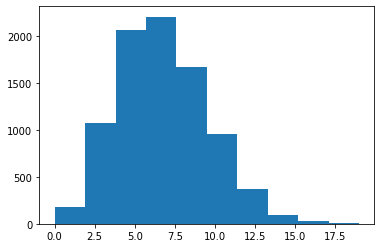

In [ ]:
# targeted
count_stat(df['pre_bigram_count'][df.Bert_embed_K_means_3_clusters==1].values.tolist())

maximum frequency of mentioning n-gram in the texts 16
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 1.7726622960516587
modal n-gram mention rate in texts 0
standard deviation of the frequency of n-gram mentioning in the texts 2.084566899985728


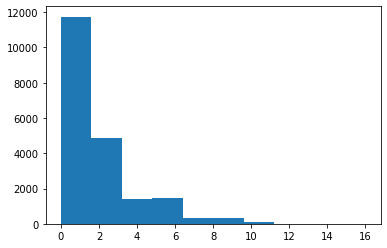

In [ ]:
# non-targeted
count_stat(df['pre_bigram_count'][df.Bert_embed_K_means_3_clusters!=1].values.tolist())

In [ ]:
# and you can see from the charts that the bigrams are good, but you have to choose them 
# so that they have a definite or at least a high probability of determining
# the text you want
#from the charts you can choose 16 to be more than the maximum.
#pre_bigram - bigrams that are more frequent in the target texts

In [ ]:
pre_bigram_count=8
print(f'how many target texts contain more {pre_bigram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.pre_bigram_count>pre_bigram_count)])}')
print(f'how many non-target texts contain more {pre_bigram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters !=1)&(df.pre_bigram_count>pre_bigram_count)])}')

how many target texts contain more 8 pre-target ngrams: 2216
how many non-target texts contain more 8 pre-target ngrams: 219


In [ ]:
# if we make the threshold for these bigrams at 8, then there is a 90% probability that the markup will be correct

In [ ]:
# what gain will the rule give
print(f'how many target texts are not processed by target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.uniq_aim_ngrams==0)])}')
print(f'how many target texts not processed by target ngrams handles pre-target ngrams with the specified threshold: {len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.uniq_aim_ngrams==0)&(df.pre_bigram_count>pre_bigram_count)])}')

how many target texts are not processed by target ngrams: 2220
how many target texts not processed by target ngrams handles pre-target ngrams with the specified threshold: 223


maximum frequency of mentioning n-gram in the texts 14
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 2.691836262719704
modal n-gram mention rate in texts 1
standard deviation of the frequency of n-gram mentioning in the texts 2.20166616643742


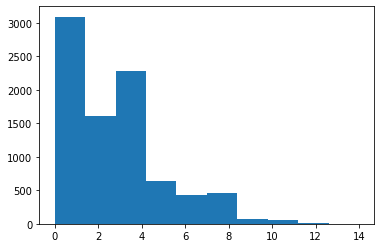

In [ ]:
count_stat(df['pre_tergram_count'][df.Bert_embed_K_means_3_clusters==1].values.tolist())

maximum frequency of mentioning n-gram in the texts 13
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 0.601025287129689
modal n-gram mention rate in texts 0
standard deviation of the frequency of n-gram mentioning in the texts 1.239471332428566


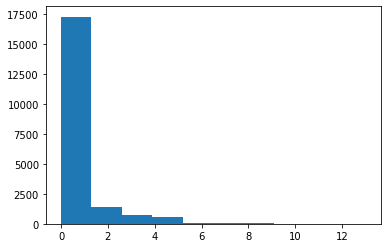

In [ ]:
count_stat(df['pre_tergram_count'][df.Bert_embed_K_means_3_clusters!=1].values.tolist())

In [ ]:
# with tergrams uninformative you can go over pre_bigram_count. accuracy is no higher than 79%
pre_tergram_count=6
print(f'how many target texts contain more {pre_tergram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.pre_tergram_count>pre_tergram_count)])}')
print(f'how many non-target texts contain more {pre_tergram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters !=1)&(df.pre_tergram_count>pre_tergram_count)])}')

how many target texts contain more 6 pre-target ngrams: 582
how many non-target texts contain more 6 pre-target ngrams: 127


maximum frequency of mentioning n-gram in the texts 12
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 0.6154024051803886
modal n-gram mention rate in texts 0
standard deviation of the frequency of n-gram mentioning in the texts 1.1845652254372547


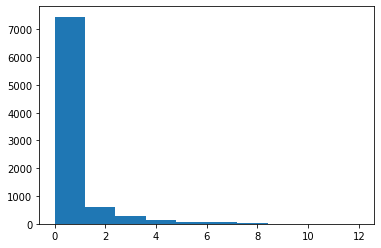

In [ ]:
count_stat(df['pre_fourgram_count'][df.Bert_embed_K_means_3_clusters==1].values.tolist())

maximum frequency of mentioning n-gram in the texts 12
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 0.1603982846157638
modal n-gram mention rate in texts 0
standard deviation of the frequency of n-gram mentioning in the texts 0.6583191754239933


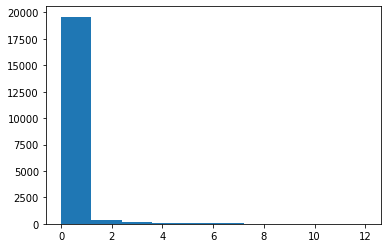

In [ ]:
count_stat(df['pre_fourgram_count'][df.Bert_embed_K_means_3_clusters!=1].values.tolist())

In [ ]:
# with tergrams uninformative you can go over pre_fourgram_count. accuracy is not higher than 45%
pre_fourgram_count=5
print(f'how many target texts contain more {pre_fourgram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.pre_fourgram_count>pre_fourgram_count)])}')
print(f'how many non-target texts contain more {pre_fourgram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters !=1)&(df.pre_fourgram_count>pre_fourgram_count)])}')

how many target texts contain more 5 pre-target ngrams: 104
how many non-target texts contain more 5 pre-target ngrams: 60


maximum frequency of mentioning n-gram in the texts 11
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 0.16211840888066606
modal n-gram mention rate in texts 0
standard deviation of the frequency of n-gram mentioning in the texts 0.7231718785999898


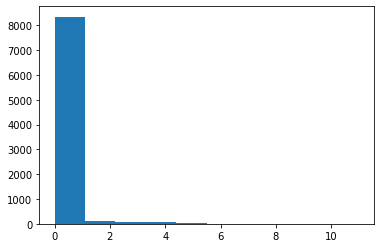

In [ ]:
count_stat(df['pre_fivegram_count'][df.Bert_embed_K_means_3_clusters==1].values.tolist())

maximum frequency of mentioning n-gram in the texts 10
minimum frequency of mentioning n-gram in the texts 0
average frequency of mentioning an n-gram in texts 0.05234879479469611
modal n-gram mention rate in texts 0
standard deviation of the frequency of n-gram mentioning in the texts 0.4219775415731911


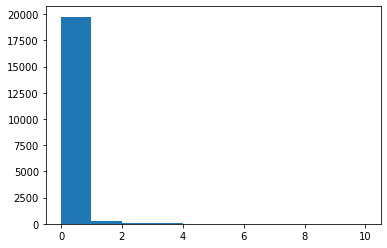

In [ ]:
count_stat(df['pre_fivegram_count'][df.Bert_embed_K_means_3_clusters!=1].values.tolist())

In [ ]:
# with fivefourgrams uninformative you can go over pre_fourgram_count. the accuracy is no higher than 25%
pre_fivegram_count=2
print(f'how many target texts contain more {pre_fivegram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters ==1)&(df.pre_fivegram_count>pre_fivegram_count)])}')
print(f'how many non-target texts contain more {pre_fivegram_count} pre-target ngrams: {len(df[(df.Bert_embed_K_means_3_clusters !=1)&(df.pre_fivegram_count>pre_fivegram_count)])}')

how many target texts contain more 2 pre-target ngrams: 185
how many non-target texts contain more 2 pre-target ngrams: 124


In [ ]:
#so I suggest only bigrams
pre_aim_bigrams_list=list(pre_aim_bigrams.keys())

In [ ]:
with open(r'besprovodnaya_svyaz__0_95_classification_pre_aim_ngrams.txt', 'w') as fp:
    for item in all_aim_ngrams:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


# Rule based part

In [ ]:
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text= re.sub(r'%', ' percent ', text)
    text=re.sub('\$', ' dollar ', text)
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub('\s+', ' ', text)  
    return text

In [ ]:
not_informative_short_words =['aaa', 'acc', 'abi', 'add', 'adt', 'aec', 'afp', 'ana', 'aol', 'apr', 'arc', 'ars', 'ash', 'atm',
                              'aud', 
                              'aug', 'avr', 'awp', 'bay', 'bbm', 'bcc', 'bci', 'ben', 'ble', 'bmi', 'boo', 'cad', 'cap', 'cbs', 
                              'ccd', 'ccp', 'ccs', 'cds', 'cee', 'ces', 'cfo', 'cgi', 'cis', 'cld', 'cns', 'cny', 'cpa', 'cta', 
                              'cto', 'cub', 'cup', 'daf', 'dan', 'daz', 'dci', 'ddr', 'dev', 'dew', 'dfc', 'dgx', 'dip', 'dlc', 
                              'dpb', 'dpi', 'dre', 'eap', 'ebt', 'eco', 'edr', 'eli', 'ems', 'eon', 'eos', 'epa', 'era', 'esa', 
                              'esi', 'etc', 'etf', 'evo', 'faa', 'fab', 'fax', 'fda', 'fed', 'fee', 'fig', 'fis', 'fla', 'fov', 
                              'gag', 'gcg', 'gdp', 'gfk', 'ghz', 'gic', 'glu', 'gos', 'gsm', 'gta', 'gtc', 'gtg', 'gtx', 'hai', 
                              'hbo', 'hed', 'hes', 'hfr', 'hlm', 'hlp', 'hmd', 'hmi', 'hon', 'htv', 'hub', 'hud', 'iab', 'iae', 
                              'ian', 'iap', 'ibd', 'ibm', 'ics', 'idc', 'idg', 'ifa', 'ign', 'igt', 'ihs', 'iii', 'imu', 'inc', 
                              'ind', 'int', 'ion', 'iot', 'ips', 'ise', 'isp', 'iss', 'ive', 'iyl', 'jio', 'jmi', 'jon', 'jun', 
                              'jwn', 'khz', 'kit', 'kwh', 'lab', 'lap', 'las', 'lbe', 'lcd', 'led', 'lgs', 'liu', 'low', 'lpm', 
                              'lrn', 'ltd', 'lte', 'lti', 'lux', 'mah', 'met', 'mhl', 'mid', 'mlg', 'mmo', 'mpg', 'mph', 'mrc', 
                              'mri', 'msc', 'msm', 'msv', 'nab', 'nba', 'nbc', 'nea', 'nfl', 'ngr', 'nov', 'nox', 'npd', 'nsf', 
                              'nsn', 'ntt', 'nuc', 'nzd', 'oak', 'oct', 'odv', 'oem', 'ohm', 'ooh', 'opi', 'opt', 'ore', 'org', 
                              'owc', 'par', 'pbr', 'pci', 'pcs', 'pct', 'phd', 'pic', 'plc', 'ppb', 'ppd', 'ppi', 'ppm', 'pre', 
                              'prn', 'pwc', 'qct', 'qqq', 'qsi', 'qtl', 'rec', 'rig', 'rim', 'rmb', 'roy', 'rpm', 'rtx', 'rue', 
                              'sad', 'sam', 'sas', 'sci', 'sek', 'shp', 'skf', 'sne', 'soc', 'spx', 'sqm', 'srp', 'stx', 'sub', 
                              'swp', 'tap', 'tcl', 'tel', 'tfe', 'thd', 'tim', 'tmr', 'tri', 'tvs', 'uav', 'ubi', 'uhd', 'uks', 
                              'usc', 'utm', 'uva', 'uvb', 'vcs', 'vfr', 'vic', 'von', 'vrd', 'vrs', 'vrx', 'wen', 'wii', 'win', 
                              'wow', 'wwe', 'wwf', 'xie', 'xlk', 'yaw', 'yoy', 'zhu', 'zvi',
                              'aal', 'aap', 'abb', 'abd', 'abp','abu', 'aci', 'acm', 'act', 'ada', 'adi', 'adl', 'adn', 'adr', 
                              'ads', 'aed', 'aeg', 'aep', 'aer', 'afr', 'agg', 'agm', 'agr', 'aha', 'ahs', 'aid', 'aii','ais',
                              'aka', 'ala', 'ali', 'alp', 'als', 'amc', 'ami', 'amn', 'amp', 'amr', 'amt', 'and', 'ant', 'anz',
                              'aok', 'api', 'app', 'aps', 'ari', 'asp', 'asu', 'asx', 'atc', 'ate', 'ati', 'atl', 'atp', 'att',
                              'atw', 'awd', 'aws', 'bac','bbb', 'bbc', 'bbk', 'bcd', 'bce', 'bch', 'bcs', 'bdt', 'beh', 'bet', 
                              'bhp', 'bia', 'bid', 'bif', 'big', 'bin', 'bip', 'bit', 'bli', 'bln', 'blu', 'bmo', 'bms', 'bmw',
                              'bns', 'bpd', 'bpi', 'bpo', 'bps', 'brl', 'bse', 'bss', 'btc', 'bts', 'btu', 'buf', 'bui','bwa', 
                              'byo', 'cae', 'caf', 'cak', 'cbp', 'ccg', 'cch', 'cci', 'ccl', 'cdc', 'cdn', 'cea', 'cem','cfe',
                              'cfs', 'cfu', 'cfx', 'cgo', 'cha', 'chd', 'chf', 'chi', 'chl', 'cho', 'chu', 'cia', 'cin', 'cio',
                              'cit', 'ckd', 'cle', 'clp',  'cmk', 'cmo', 'cmr', 'cms', 'cmt', 'cnb', 'cnc', 'cng', 'cnw', 'com',
                              'con', 'coo','co₂', 'cpc', 'cpe', 'cph', 'cpi', 'cps','cpv', 'cpw', 'crm', 'cry', 'cse', 'csl', 
                              'csm', 'csp', 'csr', 'css', 'cus', 'cut', 'cvc', 'cvg', 'cyn', 'czk', 'dab', 'dal', 'dam', 'das',
                              'dax',  'dbs', 'dcg', 'dcm', 'dda', 'ddh', 'ddt', 'dec', 'del', 'den', 'der', 'des', 'det', 'dft',
                              'dha', 'dhl', 'dhq', 'dig', 'div', 'diy', 'djb', 'dld', 'dlr', 'dmi', 'dmr', 'dna', 'dng', 'doe',
                              'dou', 'dow', 'dsc', 'dsl', 'dso', 'dsp', 'dtc', 'dth', 'dtl', 'dts', 'dtw', 'due', 'dug', 'duo',
                              'dvb',  'dvr', 'dxb', 'eas','ebs', 'eda', 'edm', 'edt', 'eee', 'ees', 'efb', 'egp', 'ehr', 'ehs',
                              'eia', 'eid', 'eir', 'emc', 'emd', 'emi', 'emt', 'emv', 'end', 'eno', 'ent', 'epc', 'epi',  'eqb',
                              'erc', 'ers', 'eso', 'est', 'etb', 'etd', 'ett', 'eur', 'eus', 'evf', 'evm', 'evs', 'ewj', 'ews',
                              'eye', 'fao', 'fat', 'fba', 'fca', 'fcc', 'fcf', 'fci', 'fcs', 'fdi', 'fdn', 'feb', 'fgw','flo',
                              'fly', 'fmc', 'fmi', 'fni', 'fon','fsa', 'fsi', 'fss', 'fst', 'ftc', 'ftr', 'fun', 'fwa', 'fxi', 
                              'gaa', 'gal', 'gan', 'gao', 'gba', 'gbe', 'gby', 'gcf', 'gee', 'gen', 'ges', 'get', 'gfg', 'ggv',
                              'ghg', 'ghs', 'gif', 'gig', 'giv', 'gla', 'gmt', 'gmv', 'gni', 'gnw', 'gpv', 'grm', 'gru', 'gsa',
                              'gsi', 'gsk', 'gst', 'gth', 'gtm', 'gto', 'gun', 'guo', 'gut', 'gva', 'gvt', 'gwe', 'gwh', 'gør',
                              'han', 'har', 'hat', 'hba', 'hbb', 'hcc', 'hcl', 'hdb', 'hdd', 'hdi', 'hdr', 'hdx', 'hem', 'hev', 
                              'hex', 'hey', 'hfc', 'hia', 'hip', 'hit','hkd', 'hkx', 'hlr', 'hns', 'hos', 'hou', 'hpc', 'hpe',
                              'hpj', 'hps', 'hrb', 'hrs', 'htc', 'hts', 'htt', 'hua', 'høy', 'iac', 'ibs', 'ibw', 'ica', 'icn',
                              'icp', 'ict', 'ida', 'idf', 'idh', 'idp', 'idx', 'ied', 'iee', 'ift', 'igr', 'igv', 'iia', 'iin', 'ijj',
                              'ill', 'imf', 'img', 'imo', 'ims', 'ina', 'ing', 'ink', 'inn', 'inr', 'ins', 'ioc', 'ioe', 'ios', 'ipc',
                              'ipd', 'ipo', 'ipr', 'ipv', 'ipx', 'iri', 'irs', 'isi', 'ism', 'itc', 'itm', 'itu', 'itv', 'iuc', 'iwd',
                              'iwf', 'iwr', 'iyt', 'izy', 'jam', 'jan', 'jet', 'jfk', 'jgp', 'jim', 'job', 'jpr', 'jpy', 'jqh', 'jsc',
                              'jui', 'jul', 'kan', 'kfc', 'kgi', 'kgs', 'kid', 'kik', 'kim', 'kkr', 'kla', 'klm', 'kmi', 'kms', 'km²',
                              'koa', 'kph', 'kpn', 'krw', 'kse', 'kts', 'kun', 'kuo', 'kva', 'kvh', 'kwd', 'laa', 'lag', 'lam', 'lan',
                              'lat', 'law', 'lay', 'lbs', 'lcc', 'lce', 'lco', 'lda', 'ldc', 'lee', 'les', 'let', 'lex', 'lgb', 'lie',
                              'lis', 'lla', 'llc', 'lmc', 'lmr', 'lng', 'log', 'loi', 'lok', 'los', 'lot', 'lpg', 'lps', 'lrs', 'lse', 
                              'lsi', 'lsp', 'lsr', 'ltm', 'lui', 'luk', 'lum', 'luo', 'lyf', 'lzo', 'lzt', 'mab',  'mag', 'man',
                              'map', 'mar', 'mat', 'mau','mbb', 'mbs', 'mbu', 'mca', 'mcd', 'mcm', 'mco', 'mdd', 'mdg', 'mdm', 'mdr', 'mea',
                              'med', 'mee', 'mem',  'meq', 'mfi', 'mhi', 'mhs', 'mhz', 'mic', 'mik', 'mil', 'mim',  'mio', 'mir', 'mis',
                              'mit', 'mix', 'mjn', 'mln', 'mms', 'mmt', 'mnf', 'mno', 'mnp', 'mod', 'mog', 'mom', 'mos', 'mou', 'moz',    
                              'mpa', 'mpc', 'mpd', 'mps', 'mrm', 'mro', 'mrp', 'msa', 'msi', 'msn', 'mss', 'mst', 'mtg', 'mtl', 'mtn', 'mts',
                              'mvp', 'mwc', 'mwh', 'máv', 'nas', 'nbn', 'ncr', 'nec', 'net', 'new', 'nfc', 'nff', 'nfv', 'ngh', 'nhk', 'nhn',
                              'nhs', 'nis', 'nok', 'non', 'npt', 'nre', 'nrf', 'nrg', 'nse', 'nsl', 'nsr', 'nsw', 'ntc', 'ntd', 'ntf', 
                              'ntp', 'ntv', 'nwe', 'nws', 'nxp', 'nxt', 'nyg', 'nyj', 'obd', 'obr', 'obs', 'ocf', 'och', 'ocs', 'odd',
                              'odm', 'oee', 'oes', 'ohb', 'oie', 'oil', 'old', 'one', 'ono', 'ons', 'ont', 'orc', 'oro', 'orr', 'osa',
                              'osk', 'ota', 'otc', 'ott', 'owe', 'oza', 'pac', 'pad', 'pan','pbs', 'pbx', 'pcb', 'pch', 'pcl', 'pcp',
                              'pds', 'pdv', 'peg', 'per', 'pet', 'pew', 'pgh', 'phe', 'phl', 'pie', 'pig', 'pin', 'pit', 'pkr', 'pla',
                              'pld', 'plm', 'pls', 'ply', 'pme', 'pnb', 'pod', 'pop', 'pos', 'pot', 'ppg', 'ppp', 'pps', 'ppv', 'prc',
                              'pro', 'prp', 'psg', 'psi', 'psy', 'pta', 'ptp', 'pts', 'pub', 'put', 'pvc', 'pyg', 'qad', 'qar',
                              'qcc', 'qfy', 'qhd', 'qnx', 'qoq', 'qvc', 'rac', 'raj', 'ram', 'ran', 'raw', 'ray', 'rba', 'rbc',
                              'rbi', 'rca', 'rcr', 'rcs', 'rda', 'rdd', 'red', 'ree', 'ren', 'rev', 'rex', 'rey', 'rgb', 'rgu', 
                              'rhi', 'rid', 'ril', 'rio', 'rkg', 'rmg', 'rmi', 'rmr', 'roa', 'roc', 'rod', 'roe', 'rog', 'roi',
                              'rom', 'ron', 'rov','rrb', 'rrh', 'rsa', 'rse', 'rsi', 'rtk', 'rub', 'run', 'rwc', 'saf', 'san',
                              'sao', 'sap', 'sar', 'sat','sba', 'sbc', 'sbi', 'sbo', 'sce', 'scs', 'sdg', 'sdn',
                              'sea', 'sec', 'see', 'sel', 'sen', 'sep', 'ses', 'set', 'sex', 'sfr', 'sgt', 'sgx', 'shy', 
                              'sia', 'sim', 'sis', 'sit', 'siy', 'ski', 'skm', 'skt', 'sky', 'slp', 'smb', 'sme', 'smg',
                              'smh', 'smk', 'smp', 'sms', 'smt', 'sns', 'soi', 'sol', 'som', 'son', 'sot', 'soy', 'spg',
                              'sph', 'spi', 'spy', 'sri', 'ssa', 'ssd', 'sse', 'ssl', 'ssm', 'std', 'stl', 'stp', 'sts',
                              'stv', 'suc', 'sud', 'sui', 'sum', 'sun', 'sur', 'suv', 'svp', 'svw', 'tab', 'tac', 'tad',
                              'tag', 'tal', 'tam', 'tan', 'tas',  'tbr', 'tbs', 'tcf', 'tcm', 'tco', 'tcs', 'tdd',
                              'tdi', 'tdk', 'tec', 'tek',  'ter', 'tex', 'tfa', 'tft', 'the', 'thz', 'tie', 'til', 
                              'tio', 'tip', 'tis', 'tls', 'tms', 'tom', 'ton', 'tpg', 'tpv', 'tpy', 'tre', 'try', 
                              'tsa', 'tse', 'tsr', 'tuc', 'tvb', 'tvc', 'twc', 'twh', 'two', 'txn', 'uae', 'uah', 
                              'ual', 'ubm', 'ubs', 'ucs', 'ufs', 'uhf', 'uhs', 'ulm', 'umc', 'und', 'une', 'upc', 
                              'upi', 'upm', 'ups', 'uqc', 'ure', 'usa', 'usb', 'usd', 'use', 'usf', 'uss', 'usv', 
                              'val', 'van', 'var', 'vas', 'vat', 'vdc', 'vdd', 'ver', 'vfc', 'vha', 'vhf', 'via',
                              'vil', 'vis', 'vnf', 'vni', 'voc', 'vod', 'vpn', 'vrf', 'vtr', 'vzw', 'wal', 'wan',
                              'wap', 'war', 'wav', 'wba', 'web', 'wed', 'wes', 'wet', 'wls', 'wos', 'wpc'
                              , 'wsj', 'wsn', 'wtg', 'www', 'xad', 'xfi', 'xia', 'xin', 'xlv', 'xmi', 'xps', 'xrp',
                              'xue', 'xzz', 'yds', 'yea', 'yen', 'yep','yfm', 'yin', 'ysa', 'ytd', 'yum', 'yun', 'zal',
                              'zee', 'zem', 'zte', 'zto',
                             'aao','abt', 'aca', 'acd', 'ach', 'ack', 'acl', 'acn', 'aco', 'acr', 'acs', 'acv', 'adb', 'adj', 'ado', 
                              'adp','aes', 'aet', 'afl', 'agc', 'agh', 'agi', 'agn','ags', 'agv', 'ahn', 'ahu', 'aig', 'alm', 'alt', 'ama',
                              'ame', 'aml', 'ams', 'amv', 'amy', 'anc','ann', 'aoc', 'aog', 'aon', 'aov', 'apa', 'apd', 'apl', 'apm', 'aqr',
                              'arr','asa', 'asc', 'asd', 'asm', 'asr', 'ata', 'atd', 'ato', 'auf', 'aum','avx', 'awe', 'axa', 'ayx', 'baa',
                              'bam', 'ban', 'bao', 'bar', 'bax', 'bba', 'bbl', 'bca', 'bcf', 'bcm', 'bct', 'bda', 'bdc',
                              'bdo', 'bds', 'bec','bep', 'bgc', 'bgf', 'bgr', 'bhi', 'bim', 'bio', 'bis', 'biu', 'biz', 'bjh', 'bjp',
                              'bjs', 'bkc', 'bkw', 'bls', 'bmc', 'bnp', 'bob', 'boe', 'bol','bpl', 'bpm', 'bpt', 'bra', 'bsa', 'bsi', 'bsv',
                              'bsx', 'bti', 'btl', 'bto', 'btw', 'bud', 'buz', 'bwc', 'cab', 'cac', 'cba', 'cbd', 'cbi', 'cbm', 'cca', 'ccb', 
                              'ccc', 'ccm', 'ccr', 'cdg', 'cdi', 'cdk', 'cdo', 'cdw', 'cdx', 'ceb', 'cec', 'cef', 'cel', 'cep', 'cet', 'cgm',
                              'cgn', 'che', 'cic', 'cke', 'cli', 'cma', 'cme', 'cmf', 'cmi', 'cml', 'cmu', 'cnk', 'cnn', 'cnt', 'cod', 'col',
                              'cor', 'cos','cpg', 'cpm', 'cpo', 'cpp', 'cpr', 'cpt', 'cpu', 'crc', 'cro', 'crv', 'csa', 'csd', 'csf', 'csi',
                              'cso', 'ctd', 'cti', 'ctr', 'cue', 'cuh', 'cvd', 'cvs', 'cwc', 'cxa', 'cxu', 'cys', 'dag', 'dai', 'dao', 'dau',
                              'dbr', 'dcc', 'dco', 'dcp', 'dds', 'dee', 'dei', 'dem', 'dfj', 'dfm', 'dhe', 'dia', 'dif', 'dik', 'dim', 'dkk', 
                              'dkr', 'dlp', 'dls', 'dmc', 'dme', 'dmf', 'dmg', 'dms', 'dnb', 'dnf', 'dno', 'doa', 'doc', 'dod', 'doi', 'doj',
                              'dos', 'dpm', 'dpu', 'drg', 'dss', 'dte', 'dtm', 'dto', 'dtt', 'dun', 'dup', 'dut','dvm', 'dvt', 'dxl', 'dye',
                              'eab', 'eam','ecj', 'ecm', 'ecs', 'edf', 'edp', 'eds', 'edu', 'eeg', 'eff', 'efm', 'egg', 'egm', 'ein', 'eiu',
                              'ekg', 'eld', 'elf', 'ema', 'emr', 'eps', 'erm', 'erp', 'erx', 'esd', 'esn', 'esp', 'eth', 'etl', 'eva', 'exa',
                              'ext', 'eys', 'faf','faq', 'far', 'fay', 'fbi', 'fbr', 'fdp', 'fep', 'fet', 'fft', 'fia', 'fin', 'fkf', 'fld',
                              'flg', 'flu', 'fos', 'fou','fpc', 'fpl', 'fps', 'frr', 'frs', 'fse', 'fsr', 'fte', 'ftk', 'ft³', 'fup', 'fyp',
                              'gac','gbi', 'gbp', 'gbs', 'gca', 'gcc', 'gel','ggr', 'ghk', 'gii', 'gle', 'glj', 'gma', 'gms', 'goa','gox', 'gpa',
                              'grc', 'grp', 'gsr', 'gsu', 'gsv', 'guy', 'gvc', 'gwp','hal', 'hbl', 'hbs', 'hci', 'hcm', 'hcq', 'hcs', 'hdl', 'hdp',
                              'hfn', 'hfo', 'hfs', 'hft', 'hhs', 'hie', 'hiv', 'hla', 'hmh', 'hmq', 'hmx', 'hny', 'hoc', 'hot', 'hrc', 'hrd', 'hsn',
                              'htf', 'htm', 'hue', 'hut', 'hvc', 'hya', 'hzb', 'hzi', 'ias', 'ibc', 'ibn', 'ibo', 'icc', 'icd','icf', 'ico', 'icu',
                              'icy', 'idm', 'ids', 'idw', 'ieg', 'ieo', 'ifr', 'ifs', 'ifx', 'igd', 'igm', 'ihc', 'ihl', 'iis', 'ijb', 'ile', 'ime',
                              'ini', 'inv', 'iod', 'iou', 'ipa', 'ipf', 'ipu', 'iqe', 'iqf', 'irc', 'ird', 'irr', 'isc', 'isg', 'ish', 'iso', 'ist',
                              'ito', 'iva', 'ivc', 'ivf', 'ivp', 'ivr', 'ivv', 'ivy', 'iwg', 'iwv', 'ixc', 'iyk', 'iyw', 'jaw', 'jda', 'jek', 'jft',
                              'jha', 'jhu', 'jit', 'jll', 'joe', 'jog', 'joy', 'jpl', 'kai', 'kar', 'kbr', 'ken','kia', 'koc', 'koh', 'kpa', 'kyc',
                              'lal', 'lau', 'lbp', 'lcs', 'ldl', 'len', 'leo', 'lev', 'lfw', 'lgp', 'lib', 'lip', 'lit', 'liv', 'liz', 'llp', 'lns',
                              'lol', 'lpd', 'lpo', 'lpt', 'ltl', 'ltv', 'luc', 'luz', 'léo','mba', 'mcg', 'mch', 'mcp', 'mcu', 'mcx', 'mdt', 'meg',
                              'mes', 'mfp', 'mgi', 'mgm', 'mig', 'min', 'mlb', 'mld', 'mmc', 'mmp', 'mol', 'moo', 'mov', 'moy', 'mpl','msh',
                              'mso', 'msp', 'msw', 'mtf', 'mtr', 'mtu', 'mtv', 'mud', 'mug', 'mum', 'mwe', 'mws', 'myo', 'myq', 'myr', 'nac',
                              'nam', 'nap', 'nav', 'nbj', 'nbv', 'ncm', 'ncs', 'ndp', 'ndr', 'ndt', 'nei', 'neo', 'neu', 'nev', 'nex', 'nfx',
                              'nga', 'ngc', 'ngi', 'ngo', 'ngp', 'ngs', 'nia', 'nic', 'nih', 'nil', 'nir', 'njm', 'nlp', 'nlu', 'nme', 'nmp',
                              'nmr', 'nmt', 'npa', 'npg', 'npr', 'nps', 'npu', 'npv', 'nra', 'nrm', 'nsa', 'nti', 'nut', 'nxj', 'nyc', 'oab',
                              'obn', 'oca', 'oda', 'ofr', 'oht', 'oig', 'oin', 'ola', 'ole', 'omb', 'opm', 'ops', 'osc', 'osi', 'oto','pag',
                              'pak', 'pal', 'pap', 'pas', 'pat', 'pau', 'pav','pcd', 'pce', 'pcu', 'pdc', 'pdf', 'pdm', 'pec', 'pep', 'pfd',
                              'pfe', 'pfi', 'pga', 'pgi', 'phi', 'php', 'phs', 'pii', 'pim', 'piv', 'pjc', 'pln', 'plp', 'pmi', 'pmp', 'pnc',
                              'pnr', 'poo', 'pou', 'ppa', 'ppl', 'ppo', 'prb', 'prm', 'prt', 'psa', 'psp', 'psr', 'pti', 'pty', 'pud', 'pus',
                              'pvd', 'pvo', 'pvs', 'pvt', 'qia', 'qrr', 'qsr', 'qts', 'que', 'rad', 'rao', 'ras','rcm', 'rct', 'ref', 'rei',
                              'rel', 'rem', 'rep', 'rfp', 'rgc', 'rhb', 'ria', 'ris', 'riv', 'rix', 'riz', 'rna', 'rnn', 'rnr', 'rop', 'row',
                              'rpa', 'rpc', 'rpx', 'rtb', 'rte', 'rti', 'rtl', 'rtp', 'ruh', 'rvx', 'rws', 'rxn','sbb', 'sbs', 'scm', 'scp', 
                              'sdi', 'sdk', 'sdl', 'sdm', 'seo', 'seu', 'sfc', 'sfi', 'sfm', 'sfn', 'sga', 'sha', 'shu', 'sic', 'sig', 'sip',
                              'six', 'ska', 'sku', 'sla', 'slb', 'sls', 'smx', 'snf', 'snr', 'soa', 'sob', 'sou', 'sow', 'sox', 'spf', 'spr',
                              'sps', 'sqe', 'sql', 'sqs', 'src', 'srm', 'sro', 'sst', 'stm', 'sto', 'sue', 'sul', 'svb', 'sve', 'svg', 'sya',
                              'syn', 'sys', 'tao', 'tav', 'tax', 'tay', 'tba', 'tbi', 'tca', 'tcp', 'tct', 'tcv', 'tdp', 'tea', 'ted', 'tem',
                              'teo', 'teu', 'tez', 'tfm', 'tgf', 'tha', 'thb', 'the', 'tif', 'tin', 'tka', 'tko', 'tma', 'tmp', 'tmt', 'tmv',
                              'tmw', 'tns', 'tnt', 'tnw', 'toc', 'toe', 'top', 'tor', 'tow', 'toy', 'tpd', 'tpm', 'tpu', 'trp', 'tru', 'tsi', 
                              'tsv', 'tsx', 'tth', 'tty', 'tvh', 'tvm', 'tvt', 'uas', 'ucc', 'ucl', 'udx', 'ugc', 'ugo', 'uhr', 'uia', 'ulg', 
                              'ull', 'umn', 'uns', 'url', 'uth', 'uto', 'uup', 'vbs', 'vca', 'vda', 'vde', 'vdw', 'vea', 'vec', 'vgb', 'vgg', 
                              'vie', 'vig', 'vii', 'vin', 'viv', 'viz', 'vku', 'vms', 'vos', 'vpa', 'vri', 'vrt', 'vte', 'way', 'wbt', 'wcs', 
                              'wee', 'wef', 'weo', 'wer', 'wfc', 'wfe', 'wfm', 'wfo', 'wit', 'wmo', 'wmt', 'wmw', 'wns', 'wpd', 'wpi', 'wpl', 
                              'wpp', 'wsi', 'wta', 'wti', 'wwt', 'xes', 'xgs', 'xlb', 'xly','xor', 'xpo', 'xrf', 'yap', 'yeo','yrd', 'yue', 'yug',
                              'yuk', 'zaf', 'zar', 'zen', 'zev', 'zip', 'zmr', 'zoo', 'zva', 'çok']


In [ ]:
# removal of English particles and prepositions.
all_stopwords = stopwords.words('english')
def delete_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [ ]:
# replacing large words derived from errors by a few words.
def preprocess_words(text):
    text = text.lower()
    text= re.sub('centralgovernment', 'central government', text)
    text= re.sub('incidentsinvolve', 'incidents involve', text)
    text= re.sub('mobilethroughout', 'mobile throughout', text)
    text= re.sub('biometricupdate', 'biometric update', text)
    text= re.sub('advertisementadjuste', 'advertisement adjuste', text)
    text= re.sub('capitalpredicte', 'capital predicte', text)
    text= re.sub('facebookconnectivitythe', 'facebook connectivity the', text)
    text= re.sub('financialsfirst', 'financials first', text)
    text= re.sub('financialsfacebook', 'financials facebook', text)
    text= re.sub('researchnreport', 'research n report', text)
    text= re.sub('accesshealthcare', 'access health care', text)
    text= re.sub('proteusdigitalhealth', 'proteus digital health', text)
    text= re.sub('renewableenergyworld', 'renewable energy world', text)
    text= re.sub('blockingpagefair', 'blocking page fair', text)
    text= re.sub('thesupermariobro', 'the supermario bro', text)
    text= re.sub('basicsmessenger', 'basics messenger', text)
    text= re.sub('communitybrands', 'community brands', text)
    text= re.sub('contributionstensorflow', 'contributions tensorflow', text)
    text= re.sub('opinionsmanagement', 'opinions management', text)
    text= re.sub('increasednumber', 'increased number', text)
    text= re.sub('salaryfinancethe', 'salary finance the', text)
    text= re.sub('securitysolution', 'security solution', text)
    text= re.sub('reduceddependence', 'reduced dependence', text)
    text= re.sub('bupivacaineinjection', 'bupivacaine injection', text)
    text= re.sub('hypersensitivity', 'hyper sensitivity', text)
    text= re.sub('membersaccording', 'members according', text)
    text= re.sub('francisprofessorsir', 'francis professors ir', text)
    text= re.sub('profileprofessor', 'profile professor', text)
    text= re.sub('advertisementtesla', 'advertisement tesla', text)
    text= re.sub('scientificconservation', 'scientific conservation', text)
    text= re.sub('respondentsdown', 'respondents down', text)
    text= re.sub('chatbotfacebook', 'chatbot facebook', text)
    text= re.sub('beforetrademark', 'before trademark', text)
    text= re.sub('marketresearchhub', 'market research hub', text)
    text= re.sub('heavyweightshive', 'heavy weights hive', text)
    text= re.sub('conclusioncitron', 'conclusion citron', text)
    text= re.sub('manufacturingwhich', 'manufacturing which', text)
    text= re.sub('globalfoundries', 'global foundries', text)
    text= re.sub('advertisementgoldman', 'advertisement goldman', text)
    text= re.sub('technologyeverything', 'technology everything', text)
    text= re.sub('coherentmarketinsights', 'coherent market insights', text)
    text= re.sub('advertisementmore', 'advertisement more', text)
    text= re.sub('breakdowndownload', 'break downdownload', text)
    text= re.sub('growthaccording', 'growth according', text)
    text= re.sub('technologytiktok', 'technology tiktok', text)
    text= re.sub('proceedingfacebook', 'proceeding facebook', text)
    text= re.sub('technologysmartphone', 'technology smartphone', text)
    text= re.sub('technologiesresearch', 'technologies research', text)
    text= re.sub('tesseraholdingcorporation', 'tessera holding corporation', text)
    text= re.sub('advertisementoverall', 'advertisement overall', text)
    text= re.sub('oldershausenmoving', 'olders haus enmoving', text)
    text= re.sub('downtimereduction', 'downtime reduction', text)
    text= re.sub('researchandmarket', 'research and market', text)
    text= re.sub('marketsandmarket', 'markets and market', text)
    text= re.sub('declarationduring', 'declaration during', text)
    text= re.sub('qualityexperience', 'quality experience', text)
    text= re.sub('summarycomputing', 'summary computing', text)
    text= re.sub('alliancebernstein', 'alliance bernstein', text)
    text= re.sub('crystaldiskmark', 'crystal diskmark', text)
    text= re.sub('marketandmarket', 'market and market', text)
    text= re.sub('jbknowledge\u200b', 'knowledge', text)
    text= re.sub('qualcomm\x92s', 'qualcomm', text)
    text= re.sub('jvckenwood', 'kenwood', text)
    text= re.sub('broad\xadcast', 'broadcast', text)
    text= re.sub('informationstored', 'information stored', text)
    text= re.sub('facebookalthough', 'facebook although', text)
    text= re.sub('advertisementthe', 'advertisement the', text)
    text= re.sub('playstationnetwork', 'playstation network', text)
    return text

In [ ]:
nlp = spacy.load('en_core_web_lg')
def rule_market_growth_claim(string,aim_ngrams,pre_aims_and_borders):
    '''
    string - string to be defined
    aim_ngrams - the list of ngrams, the presence of which unambiguously determines the target class
    pre_aims_and_borders - list of lists of the form [[[ngrams],border],[ngrams1],border1],....]
    '''
    success=False # indicator that this is the right text
    # first all the preprocessing as before
    string = preprocess(string)
    string = delete_stop_words(string)
    string = ' '.join( [word for word in string.split() if len(word)>2])
    string = ' '.join( [word for word in string.split() if word not in not_informative_short_words])
    string = preprocess_words(string)
    string = " ".join([token.lemma_ for token in nlp(string)])
    for ngram in aim_ngrams:
        if ngram in string:
            success=True
            return success
    for ngrams_and_borders in pre_aims_and_borders:
        ngrams=ngrams_and_borders[0]
        border=ngrams_and_borders[1] # boundary is the threshold above which we can download with some certainty that this is the target text
        counter=0
        for ngram in ngrams:
            if ngram in string:
                counter+=1
                if counter > border:
                    success=True
                    return success
    return success

In [ ]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [ ]:
df = pd.read_excel('besprovodnaya_svyaz__0_95_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28929 entries, 0 to 28934
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sentence  28929 non-null  string 
 1   class     28929 non-null  float64
dtypes: float64(1), string(1)
memory usage: 678.0 KB
None


In [ ]:
aim_ngrams_file = open("besprovodnaya_svyaz__0_95_classification_aim_ngrams.txt", "r")
aim_ngrams = aim_ngrams_file.read().splitlines()
pre_aim_ngrams_file = open("besprovodnaya_svyaz__0_95_classification_pre_aim_ngrams.txt", "r")
pre_aim_ngrams = pre_aim_ngrams_file.read().splitlines()
new_pre_aim_ngrams=[[pre_aim_ngrams,8]]

In [ ]:
# Example
#new_pre_aim_ngrams=[[pre_aim_ngrams,8],[pre_aim_ngrams2,7],......]

In [ ]:
df['rule_result']=df.sentence.apply(lambda x: rule_market_growth_claim(x,aim_ngrams,new_pre_aim_ngrams))


In [ ]:
df

,sentence,class,rule_result
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,1.0,True
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,1.0,False
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",0.0,False
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,1.0,True
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",1.0,False
5,So Nvidia’s automotive revenue has doubled from $320 million in fiscal 2016 to $640 million in fiscal 2019.,1.0,True
6,Game consoles were added in fiscal 2017.Nvidia’s Tegra revenue rose almost threefold from $559 million in fiscal 2016 to $1.54 billion in fiscal 2019.,1.0,True
7,"Back in fiscal 2016, Nvidia earned 5% of its revenue—or $264 million—from licensing.",1.0,False
8,"Moreover, it’s expected to outperform the market, even in 2019.The WSTS (World Semiconductor Trade Statistics) expects global semiconductor revenue to fall 12.8% in 2019.",1.0,True
9,"The Ericsson Report 2019 estimates 2.6 billion 5G subscriptions globally by 2025, accounting for 29% of all mobile subscriptions at that time.",0.0,False


In [ ]:
df['rule_result']=df['rule_result'].apply(lambda x: 1 if x else 0)

In [ ]:
df

,sentence,class,rule_result
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,1.0,1
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,1.0,0
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",0.0,0
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,1.0,1
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",1.0,0
5,So Nvidia’s automotive revenue has doubled from $320 million in fiscal 2016 to $640 million in fiscal 2019.,1.0,1
6,Game consoles were added in fiscal 2017.Nvidia’s Tegra revenue rose almost threefold from $559 million in fiscal 2016 to $1.54 billion in fiscal 2019.,1.0,1
7,"Back in fiscal 2016, Nvidia earned 5% of its revenue—or $264 million—from licensing.",1.0,0
8,"Moreover, it’s expected to outperform the market, even in 2019.The WSTS (World Semiconductor Trade Statistics) expects global semiconductor revenue to fall 12.8% in 2019.",1.0,1
9,"The Ericsson Report 2019 estimates 2.6 billion 5G subscriptions globally by 2025, accounting for 29% of all mobile subscriptions at that time.",0.0,0


In [ ]:
y_class=df.iloc[0:150,1].values.tolist()
y_class=[int(x) for x in y_class]
y_class

[1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0]

In [ ]:
y_pred=df.iloc[0:150,2].values.tolist()
y_pred=[int(x) for x in y_pred]
y_pred

[1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0]

In [ ]:
df.to_excel('bespr_svyaz_result.xlsx')

In [ ]:
compute_accuracy(y_class, y_pred)

0.8066666666666666